In [3]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [4]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 20016, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 20016 (delta 149), reused 131 (delta 129), pack-reused 19846 (from 3)
Receiving objects: 100% (20016/20016), 106.95 MiB | 37.16 MiB/s, done.
Resolving deltas: 100% (427/427), done.
Updating files: 100% (79/79), done.


In [5]:
import os
os.chdir('/content/GeoDecepticon')

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy
from GeneralViT import VisionTransformer, create_model
from tqdm import tqdm  # For progress bars

# Load and plot training data

(9000, 60, 60)


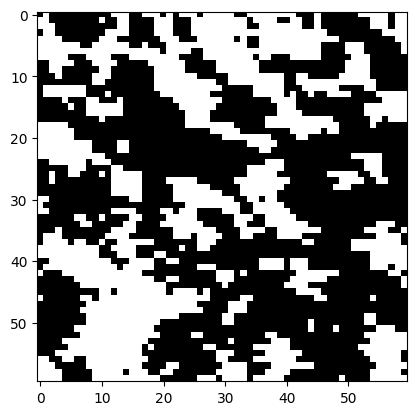

In [7]:
arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
# We reshape it to 60x60 dataset
training_data = training_data.reshape(-1, 64, 64)
test_data = test_data.reshape(-1, 64, 64)
training_data = training_data[:,:60,:60]
test_data = test_data[:,:60,:60]
print(training_data.shape)
training_data = torch.tensor(training_data,dtype=torch.float32)
test_data = torch.tensor(test_data,dtype=torch.float32)
#plot the first data
plt.imshow(training_data[0],cmap='gray')
plt.show()

# ChatGPT o3-mini-high approach

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt  # used only if you want to show local plots

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Helper: Image sampling
########################################

def sample_image_conditional(model, patch_size, image_size, temperature=1.0, condition_indices=None, condition_values=None):
    """
    Generate one image using the autoregressive model while enforcing conditions.
    - condition_indices: numpy array of global pixel indices (from a flattened 60x60 image)
    - condition_values: numpy array of binary values corresponding to these indices.

    Returns: (generated, log_likelihood)
      - generated: a tensor of shape (1, num_patches, patch_dim)
      - log_likelihood: the sum of log-probabilities for each patch token.
    """
    num_patches = (image_size // patch_size) ** 2
    patch_dim = patch_size * patch_size

    # Initialize generated patches with the model's mask token.
    generated = model.mask_token.detach().clone().unsqueeze(0).repeat(num_patches, 1)  # (num_patches, patch_dim)
    log_likelihood = 0.0

    # Pre-compute patch-level conditions.
    # Create a dictionary mapping patch index -> dict {local_index: condition_value}
    patch_conditions = {}
    if condition_indices is not None and condition_values is not None:
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            # Convert global pixel index to (row, col)
            global_row = int(cond_idx) // image_size
            global_col = int(cond_idx) % image_size
            # Determine which patch this falls into:
            patch_row = global_row // patch_size
            patch_col = global_col // patch_size
            num_patches_per_row = image_size // patch_size
            patch_index = patch_row * num_patches_per_row + patch_col
            # Determine local index within the patch:
            local_row = global_row % patch_size
            local_col = global_col % patch_size
            local_index = local_row * patch_size + local_col
            if patch_index not in patch_conditions:
                patch_conditions[patch_index] = {}
            patch_conditions[patch_index][local_index] = float(cond_val)

    generated = generated.unsqueeze(0)  # shape: (1, num_patches, patch_dim)
    # Sequentially generate patch tokens in raster-scan order.
    for i in range(num_patches):
        # If conditions exist for this patch, get them.
        cond = patch_conditions.get(i, None)
        # Forward pass: compute logits for the entire sequence.
        logits = model(generated)  # shape: (1, num_patches, vocab_size)
        logits_i = logits[0, i] / temperature  # (vocab_size,)
        if cond is not None:
            # For each conditioned local pixel, restrict the distribution.
            candidate_mask = torch.ones(model.vocab_size, dtype=torch.bool, device=logits_i.device)
            for local_idx, cond_val in cond.items():
                # For each token, check if its value at local_idx matches the condition.
                candidate_mask = candidate_mask & (model.vocab[:, local_idx] == cond_val)
            logits_i = logits_i.masked_fill(~candidate_mask, -1e9)
        probs = torch.softmax(logits_i, dim=-1)
        token = torch.multinomial(probs, num_samples=1)
        # Accumulate log probability.
        log_prob = torch.log(probs[token] + 1e-10)  # add epsilon for stability
        log_likelihood += log_prob.item()
        # Lookup the corresponding patch token from the vocabulary.
        patch = model.vocab[token]
        generated[0, i] = patch
    return generated, log_likelihood

########################################
# Vision Transformer and Vocabulary
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        # training_data assumed shape: (N, H, W)
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)
        # Extract patches with unfold.
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)
        # Build vocabulary (for discrete targets) with progress bar.
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        # Add a full mask token to the vocabulary (if desired)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        # Add one-mask tokens (for each patch position, forcing one pixel observed)
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)

        self.vocab = torch.stack(unique_list)  # shape: (vocab_size, patch_dim)
        self.vocab_size = self.vocab.size(0)
        # Precompute integer codes for vocabulary tokens.
        self.vocab_int = patch_to_int(self.vocab)
        # Embedding projection: from patch_dim to hidden_dim.
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        # Output projection: from hidden_dim to vocab size.
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        # Learned positional encoding.
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        # --- Learnable Mask Token ---
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))
        return self.vocab

    def forward(self, patches):
        # patches shape: (B, num_patches, patch_dim)
        B, num_patches, _ = patches.shape
        embeddings = self.embedding_projection(patches)
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        for layer in self.transformer_layers:
            z = layer(z)
        logits = self.output_projection(z)  # shape: (B, num_patches, vocab_size)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # shape: (N, H, W)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx]
    @staticmethod
    def batch_to_patches(images, patch_size):
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches
    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # patches: (num_patches, patch_dim) assumed ordered in raster scan.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Autoregressive Conditional Sampling Function
########################################

def sample_image(model, patch_size, image_size, temperature=1.0, observed_indices=None, observed_tokens=None):
    """
    Generates one image (as a tensor of patches) in a sequential (raster scan) manner.
    - observed_indices: list or tensor of indices (0-indexed) that are given as context.
    - observed_tokens: tensor of shape (len(observed_indices), patch_dim) with the observed patch values.
    """
    num_patches = (image_size // patch_size) ** 2
    patch_dim = patch_size * patch_size
    # Start with all patches set to the mask token.
    generated = model.mask_token.detach().clone().unsqueeze(0).repeat(num_patches, 1)  # (num_patches, patch_dim)
    # If context is provided, replace those positions.
    if observed_indices is not None and observed_tokens is not None:
        generated[observed_indices] = observed_tokens
    # Reshape to (1, num_patches, patch_dim)
    generated = generated.unsqueeze(0)
    # Sequentially sample for positions not in the context.
    for i in range(num_patches):
        if observed_indices is not None and i in observed_indices:
            continue  # skip positions that are given
        # Forward pass: we compute logits for the entire sequence.
        logits = model(generated)  # shape: (1, num_patches, vocab_size)
        logits_i = logits[0, i] / temperature
        probs = torch.softmax(logits_i, dim=-1)
        token = torch.multinomial(probs, num_samples=1)
        # Look up the corresponding patch from the vocabulary.
        patch = model.vocab[token]
        generated[0, i] = patch
    return generated  # shape: (1, num_patches, patch_dim)

########################################
# Training Pipeline
########################################

def train_model_for_patch(patch_size, training_data, num_epochs=1000, batch_size=128):
    # Hyperparameters.
    # Increased model capacity.
    num_heads = 8
    num_layers = 8        # increased layers
    ffn_dim = 1024        # increased FFN dimension
    hidden_dim = 256      # increased hidden dimension

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]  # assume square images

    # Initialize wandb run.
    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "num_epochs": num_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}",
               reinit=True)

    # Build model and vocabulary.
    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = patch_to_int(model.vocab).to(device)  # Precompute vocab integer codes.

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop.
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Determine a mask rate schedule:
        # Ensure at least one patch is masked.
        num_patches = (image_size // patch_size) ** 2
        min_mask_rate = 1.0 / num_patches
        base_mask_rate = min_mask_rate + (1.0 - min_mask_rate) * (epoch / num_epochs)
        # Add a random fluctuation in the range [-0.1, 0.1].
        mask_rate = np.clip(base_mask_rate + np.random.uniform(-0.1, 0.1), min_mask_rate, 1.0)
        partial_mask_rate = 0.3  # Keep 30% of masked patches as partial.

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)  # (B, num_patches, patch_dim)
            num_patches = patches.shape[1]
            patch_dim = patches.shape[2]

            # Create mask: for each patch in each image, mask with probability = mask_rate.
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            # Ensure at least one masked patch per sample.
            mask[:, 0] = True

            # Decide which masked patches are partial.
            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            # Replace fully masked patches with the learnable mask token.
            if full.any():
                masked_patches[full] = model.mask_token
            # For partial masks, fill with 0.5 and then restore one random pixel.
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Forward pass.
            logits = model(masked_patches)  # (B, num_patches, vocab_size)
            # --- Full Target Computation ---
            all_patches = patches.view(B * num_patches, patch_dim)
            codes = patch_to_int(all_patches)  # (B*num_patches,)
            vocab_codes = model.vocab_int  # (vocab_size,)
            mask_eq = codes.unsqueeze(1) == vocab_codes.unsqueeze(0)
            target_indices = mask_eq.float().argmax(dim=1)
            targets_all = target_indices.view(B, num_patches)
            # Compute loss over all patches.
            loss = criterion(logits.view(-1, model.vocab_size), targets_all.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)

        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # --- Visualization on First Batch ---
        model.eval()
        with torch.no_grad():
            batch0 = next(iter(dataloader)).to(device)
            patches0 = BinaryImageDataset.batch_to_patches(batch0, patch_size)
            B0, num_patches, patch_dim = patches0.shape
            # Create a mask for visualization with shape [1, num_patches] then squeeze.
            vis_mask = (torch.rand(1, num_patches, device=device) < mask_rate)
            vis_mask[:, 0] = True
            vis_mask = vis_mask.squeeze(0)  # Now shape: [num_patches]

            vis_partial = (torch.rand(1, num_patches, device=device) < partial_mask_rate).squeeze(0) & vis_mask
            vis_full = vis_mask & (~vis_partial)

            masked_vis = patches0[0].clone()  # shape: [num_patches, patch_dim]
            if vis_full.any():
                masked_vis[vis_full] = model.mask_token
            if vis_partial.any():
                partial_idx_vis = torch.nonzero(vis_partial)
                num_partial_vis = partial_idx_vis.shape[0]
                new_patches_vis = torch.full((num_partial_vis, patch_dim), 0.5, device=device)
                rand_positions_vis = torch.randint(0, patch_dim, (num_partial_vis,), device=device)
                # Use the indices from partial_idx_vis (which now are 1D indices).
                orig_vals_vis = patches0[0, partial_idx_vis[:, 0], :].gather(1, rand_positions_vis.unsqueeze(1)).squeeze(1)
                new_patches_vis[torch.arange(num_partial_vis), rand_positions_vis] = orig_vals_vis
                masked_vis[partial_idx_vis[:, 0]] = new_patches_vis

            # Reconstruction: run model on masked_vis.
            logits_vis = model(masked_vis.unsqueeze(0))
            recon_tokens = torch.argmax(logits_vis, dim=-1).squeeze(0)
            recon_patches = model.vocab[recon_tokens]
            masked_img = BinaryImageDataset.patches_to_image(masked_vis, patch_size, image_size)
            recon_img = BinaryImageDataset.patches_to_image(recon_patches, patch_size, image_size)
            original_img = BinaryImageDataset.patches_to_image(patches0[0], patch_size, image_size)
            wandb.log({
                "original": wandb.Image(original_img.cpu()),
                "masked": wandb.Image(masked_img.cpu()),
                "reconstructed": wandb.Image(recon_img.cpu())
            })

        # --- Every 100 Epochs: Conditional Sampling using given conditions ---
        if (epoch + 1) % 100 == 0:
            # Provided condition indices and values (global indices for a 60x60 image)
            condition_indices = np.array([876,2825,2122,2892,1556,2683,2667,1767,483,2351,2000,3312,2953,289,
                                          2373,2720,872,2713,1206,1341,3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
            condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])
            # Use the conditional sampling function.
            gen, ll = sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                                              condition_indices=condition_indices,
                                              condition_values=condition_values)
            # Convert generated patches back to an image.
            gen_img = BinaryImageDataset.patches_to_image(gen[0], patch_size, image_size)
            wandb.log({"conditional_sample": wandb.Image(gen_img.cpu(), caption=f"LL: {ll:.2f}")})

        # Save checkpoint every 100 epochs.
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")

    wandb.finish()
    return model

########################################
# Main: Train All Models
########################################

if __name__ == "__main__":
    # Load training data (assumed shape: (9000, 60, 60))
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    # Reshape to 60x60 images.
    training_data = training_data.reshape(-1, 64, 64)[:, :60, :60]
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)

    # Train models for patch sizes 2x2, 3x3, and 4x4.
    patch_size = 4
    model = train_model_for_patch(patch_size, training_data)

Training data shape: (9000, 60, 60)


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
loss,▂▅▃▂▃▆▃▃█▄██▇▄▃▅▃▃▃▂▃▂▂▁▂▇▆▆▁▆▇█▁▂▄▆▁▇▆▁
mask_rate,▂▃▂▄▅▃▃▃▄▆▂▆▆▃▅▆▆▃█▅▁▄▃▆▄▃▃▃▁▅▇▃▂▆█▇█▇▄▂
epoch,123
loss,5.20841
mask_rate,0.99801


Building Vocabulary for 4x4: 100%|██████████| 2025000/2025000 [00:48<00:00, 41895.78it/s]


[Patch 4x4] Epoch 1/1000, Loss: 4.4902, Mask Rate: 0.02


[Patch 4x4] Epoch 2/1000, Loss: 0.9552, Mask Rate: 0.06


[Patch 4x4] Epoch 3/1000, Loss: 0.2558, Mask Rate: 0.00


[Patch 4x4] Epoch 4/1000, Loss: 0.6337, Mask Rate: 0.08


[Patch 4x4] Epoch 5/1000, Loss: 0.3571, Mask Rate: 0.04


[Patch 4x4] Epoch 6/1000, Loss: 0.7050, Mask Rate: 0.10


[Patch 4x4] Epoch 7/1000, Loss: 0.1077, Mask Rate: 0.00


[Patch 4x4] Epoch 8/1000, Loss: 0.7156, Mask Rate: 0.10


[Patch 4x4] Epoch 9/1000, Loss: 0.0924, Mask Rate: 0.00


[Patch 4x4] Epoch 10/1000, Loss: 0.5624, Mask Rate: 0.08


[Patch 4x4] Epoch 11/1000, Loss: 0.0830, Mask Rate: 0.00


[Patch 4x4] Epoch 12/1000, Loss: 0.0789, Mask Rate: 0.00


[Patch 4x4] Epoch 13/1000, Loss: 0.4350, Mask Rate: 0.06


[Patch 4x4] Epoch 14/1000, Loss: 0.2622, Mask Rate: 0.04


[Patch 4x4] Epoch 15/1000, Loss: 0.0742, Mask Rate: 0.00


[Patch 4x4] Epoch 16/1000, Loss: 0.1217, Mask Rate: 0.01


[Patch 4x4] Epoch 17/1000, Loss: 0.3995, Mask Rate: 0.06


[Patch 4x4] Epoch 18/1000, Loss: 0.0711, Mask Rate: 0.00


[Patch 4x4] Epoch 19/1000, Loss: 0.7758, Mask Rate: 0.12


[Patch 4x4] Epoch 20/1000, Loss: 0.7218, Mask Rate: 0.11


[Patch 4x4] Epoch 21/1000, Loss: 0.3444, Mask Rate: 0.05


[Patch 4x4] Epoch 22/1000, Loss: 0.4129, Mask Rate: 0.06


[Patch 4x4] Epoch 23/1000, Loss: 0.6077, Mask Rate: 0.10


[Patch 4x4] Epoch 24/1000, Loss: 0.4493, Mask Rate: 0.07


[Patch 4x4] Epoch 25/1000, Loss: 0.6076, Mask Rate: 0.10


[Patch 4x4] Epoch 26/1000, Loss: 0.4992, Mask Rate: 0.08


[Patch 4x4] Epoch 27/1000, Loss: 0.3934, Mask Rate: 0.06


[Patch 4x4] Epoch 28/1000, Loss: 0.6728, Mask Rate: 0.11


[Patch 4x4] Epoch 29/1000, Loss: 0.0680, Mask Rate: 0.01


[Patch 4x4] Epoch 30/1000, Loss: 0.2067, Mask Rate: 0.03


[Patch 4x4] Epoch 31/1000, Loss: 0.5548, Mask Rate: 0.09


[Patch 4x4] Epoch 32/1000, Loss: 0.3126, Mask Rate: 0.05


[Patch 4x4] Epoch 33/1000, Loss: 0.1208, Mask Rate: 0.02


[Patch 4x4] Epoch 34/1000, Loss: 0.6514, Mask Rate: 0.11


[Patch 4x4] Epoch 35/1000, Loss: 0.7042, Mask Rate: 0.12


[Patch 4x4] Epoch 36/1000, Loss: 0.5435, Mask Rate: 0.09


[Patch 4x4] Epoch 37/1000, Loss: 0.7783, Mask Rate: 0.13


[Patch 4x4] Epoch 38/1000, Loss: 0.2548, Mask Rate: 0.04


[Patch 4x4] Epoch 39/1000, Loss: 0.0574, Mask Rate: 0.00


[Patch 4x4] Epoch 40/1000, Loss: 0.3426, Mask Rate: 0.06


[Patch 4x4] Epoch 41/1000, Loss: 0.0559, Mask Rate: 0.00


[Patch 4x4] Epoch 42/1000, Loss: 0.6734, Mask Rate: 0.11


[Patch 4x4] Epoch 43/1000, Loss: 0.1304, Mask Rate: 0.02


[Patch 4x4] Epoch 44/1000, Loss: 0.0543, Mask Rate: 0.00


[Patch 4x4] Epoch 45/1000, Loss: 0.3413, Mask Rate: 0.06


[Patch 4x4] Epoch 46/1000, Loss: 0.1647, Mask Rate: 0.02


[Patch 4x4] Epoch 47/1000, Loss: 0.3752, Mask Rate: 0.06


[Patch 4x4] Epoch 48/1000, Loss: 0.4845, Mask Rate: 0.08


[Patch 4x4] Epoch 49/1000, Loss: 0.0717, Mask Rate: 0.01


[Patch 4x4] Epoch 50/1000, Loss: 0.7225, Mask Rate: 0.12


[Patch 4x4] Epoch 51/1000, Loss: 0.6751, Mask Rate: 0.12


[Patch 4x4] Epoch 52/1000, Loss: 0.2979, Mask Rate: 0.05


[Patch 4x4] Epoch 53/1000, Loss: 0.7714, Mask Rate: 0.13


[Patch 4x4] Epoch 54/1000, Loss: 0.6668, Mask Rate: 0.11


[Patch 4x4] Epoch 55/1000, Loss: 0.0416, Mask Rate: 0.00


[Patch 4x4] Epoch 56/1000, Loss: 0.0394, Mask Rate: 0.00


[Patch 4x4] Epoch 57/1000, Loss: 0.8957, Mask Rate: 0.16


[Patch 4x4] Epoch 58/1000, Loss: 0.0419, Mask Rate: 0.01


[Patch 4x4] Epoch 59/1000, Loss: 0.3728, Mask Rate: 0.07


[Patch 4x4] Epoch 60/1000, Loss: 0.3231, Mask Rate: 0.06


[Patch 4x4] Epoch 61/1000, Loss: 0.7111, Mask Rate: 0.13


[Patch 4x4] Epoch 62/1000, Loss: 0.1884, Mask Rate: 0.03


[Patch 4x4] Epoch 63/1000, Loss: 0.2114, Mask Rate: 0.04


[Patch 4x4] Epoch 64/1000, Loss: 0.1941, Mask Rate: 0.04


[Patch 4x4] Epoch 65/1000, Loss: 0.2740, Mask Rate: 0.06


[Patch 4x4] Epoch 66/1000, Loss: 0.2944, Mask Rate: 0.06


[Patch 4x4] Epoch 67/1000, Loss: 0.0297, Mask Rate: 0.00


[Patch 4x4] Epoch 68/1000, Loss: 0.3783, Mask Rate: 0.08


[Patch 4x4] Epoch 69/1000, Loss: 0.3463, Mask Rate: 0.07


[Patch 4x4] Epoch 70/1000, Loss: 0.1548, Mask Rate: 0.03


[Patch 4x4] Epoch 71/1000, Loss: 0.4908, Mask Rate: 0.11


[Patch 4x4] Epoch 72/1000, Loss: 0.3653, Mask Rate: 0.08


[Patch 4x4] Epoch 73/1000, Loss: 0.3278, Mask Rate: 0.07


[Patch 4x4] Epoch 74/1000, Loss: 0.0602, Mask Rate: 0.01


[Patch 4x4] Epoch 75/1000, Loss: 0.4575, Mask Rate: 0.10


[Patch 4x4] Epoch 76/1000, Loss: 0.0779, Mask Rate: 0.02


[Patch 4x4] Epoch 77/1000, Loss: 0.4927, Mask Rate: 0.11


[Patch 4x4] Epoch 78/1000, Loss: 0.5600, Mask Rate: 0.12


[Patch 4x4] Epoch 79/1000, Loss: 0.0322, Mask Rate: 0.01


[Patch 4x4] Epoch 80/1000, Loss: 0.7920, Mask Rate: 0.18


[Patch 4x4] Epoch 81/1000, Loss: 0.4583, Mask Rate: 0.11


[Patch 4x4] Epoch 82/1000, Loss: 0.7135, Mask Rate: 0.17


[Patch 4x4] Epoch 83/1000, Loss: 0.3081, Mask Rate: 0.07


[Patch 4x4] Epoch 84/1000, Loss: 0.1863, Mask Rate: 0.05


[Patch 4x4] Epoch 85/1000, Loss: 0.2411, Mask Rate: 0.06


[Patch 4x4] Epoch 86/1000, Loss: 0.7079, Mask Rate: 0.17


[Patch 4x4] Epoch 87/1000, Loss: 0.7258, Mask Rate: 0.18


[Patch 4x4] Epoch 88/1000, Loss: 0.7324, Mask Rate: 0.18


[Patch 4x4] Epoch 89/1000, Loss: 0.7342, Mask Rate: 0.18


[Patch 4x4] Epoch 90/1000, Loss: 0.6463, Mask Rate: 0.16


[Patch 4x4] Epoch 91/1000, Loss: 0.4547, Mask Rate: 0.11


[Patch 4x4] Epoch 92/1000, Loss: 0.5891, Mask Rate: 0.15


[Patch 4x4] Epoch 93/1000, Loss: 0.1244, Mask Rate: 0.03


[Patch 4x4] Epoch 94/1000, Loss: 0.2126, Mask Rate: 0.06


[Patch 4x4] Epoch 95/1000, Loss: 0.7746, Mask Rate: 0.19


[Patch 4x4] Epoch 96/1000, Loss: 0.5826, Mask Rate: 0.15


[Patch 4x4] Epoch 97/1000, Loss: 0.7422, Mask Rate: 0.19


[Patch 4x4] Epoch 98/1000, Loss: 0.6001, Mask Rate: 0.15


[Patch 4x4] Epoch 99/1000, Loss: 0.3841, Mask Rate: 0.10


[Patch 4x4] Epoch 100/1000, Loss: 0.5104, Mask Rate: 0.13


[Patch 4x4] Epoch 101/1000, Loss: 0.5876, Mask Rate: 0.15


[Patch 4x4] Epoch 102/1000, Loss: 0.3836, Mask Rate: 0.10


[Patch 4x4] Epoch 103/1000, Loss: 0.0263, Mask Rate: 0.01


[Patch 4x4] Epoch 104/1000, Loss: 0.6932, Mask Rate: 0.18


[Patch 4x4] Epoch 105/1000, Loss: 0.4825, Mask Rate: 0.13


[Patch 4x4] Epoch 106/1000, Loss: 0.7682, Mask Rate: 0.20


[Patch 4x4] Epoch 107/1000, Loss: 0.0757, Mask Rate: 0.02


[Patch 4x4] Epoch 108/1000, Loss: 0.8234, Mask Rate: 0.21


[Patch 4x4] Epoch 109/1000, Loss: 0.0667, Mask Rate: 0.02


[Patch 4x4] Epoch 110/1000, Loss: 0.8002, Mask Rate: 0.21


[Patch 4x4] Epoch 111/1000, Loss: 0.4604, Mask Rate: 0.12


[Patch 4x4] Epoch 112/1000, Loss: 0.4727, Mask Rate: 0.13


[Patch 4x4] Epoch 113/1000, Loss: 0.4687, Mask Rate: 0.12


[Patch 4x4] Epoch 114/1000, Loss: 0.3411, Mask Rate: 0.09


[Patch 4x4] Epoch 115/1000, Loss: 0.0744, Mask Rate: 0.02


[Patch 4x4] Epoch 116/1000, Loss: 0.5794, Mask Rate: 0.15


[Patch 4x4] Epoch 117/1000, Loss: 0.6514, Mask Rate: 0.17


[Patch 4x4] Epoch 118/1000, Loss: 0.6385, Mask Rate: 0.17


[Patch 4x4] Epoch 119/1000, Loss: 0.2360, Mask Rate: 0.06


[Patch 4x4] Epoch 120/1000, Loss: 0.2566, Mask Rate: 0.07


[Patch 4x4] Epoch 121/1000, Loss: 0.2192, Mask Rate: 0.06


[Patch 4x4] Epoch 122/1000, Loss: 0.6908, Mask Rate: 0.18


[Patch 4x4] Epoch 123/1000, Loss: 0.8104, Mask Rate: 0.21


[Patch 4x4] Epoch 124/1000, Loss: 0.5134, Mask Rate: 0.14


[Patch 4x4] Epoch 125/1000, Loss: 0.1027, Mask Rate: 0.03


[Patch 4x4] Epoch 126/1000, Loss: 0.4896, Mask Rate: 0.13


[Patch 4x4] Epoch 127/1000, Loss: 0.2292, Mask Rate: 0.06


[Patch 4x4] Epoch 128/1000, Loss: 0.4179, Mask Rate: 0.11


[Patch 4x4] Epoch 129/1000, Loss: 0.3128, Mask Rate: 0.09


[Patch 4x4] Epoch 130/1000, Loss: 0.4879, Mask Rate: 0.13


[Patch 4x4] Epoch 131/1000, Loss: 0.4365, Mask Rate: 0.12


[Patch 4x4] Epoch 132/1000, Loss: 0.5612, Mask Rate: 0.15


[Patch 4x4] Epoch 133/1000, Loss: 0.4018, Mask Rate: 0.11


[Patch 4x4] Epoch 134/1000, Loss: 0.6890, Mask Rate: 0.19


[Patch 4x4] Epoch 135/1000, Loss: 0.3935, Mask Rate: 0.11


[Patch 4x4] Epoch 136/1000, Loss: 0.4641, Mask Rate: 0.13


[Patch 4x4] Epoch 137/1000, Loss: 0.1755, Mask Rate: 0.05


[Patch 4x4] Epoch 138/1000, Loss: 0.5206, Mask Rate: 0.14


[Patch 4x4] Epoch 139/1000, Loss: 0.9139, Mask Rate: 0.24


[Patch 4x4] Epoch 140/1000, Loss: 0.5623, Mask Rate: 0.16


[Patch 4x4] Epoch 141/1000, Loss: 0.2925, Mask Rate: 0.08


[Patch 4x4] Epoch 142/1000, Loss: 0.5864, Mask Rate: 0.16


[Patch 4x4] Epoch 143/1000, Loss: 0.1776, Mask Rate: 0.05


[Patch 4x4] Epoch 144/1000, Loss: 0.6654, Mask Rate: 0.18


[Patch 4x4] Epoch 145/1000, Loss: 0.3445, Mask Rate: 0.10


[Patch 4x4] Epoch 146/1000, Loss: 0.2461, Mask Rate: 0.07


[Patch 4x4] Epoch 147/1000, Loss: 0.5986, Mask Rate: 0.17


[Patch 4x4] Epoch 148/1000, Loss: 0.2100, Mask Rate: 0.06


[Patch 4x4] Epoch 149/1000, Loss: 0.4474, Mask Rate: 0.13


[Patch 4x4] Epoch 150/1000, Loss: 0.2270, Mask Rate: 0.07


[Patch 4x4] Epoch 151/1000, Loss: 0.2252, Mask Rate: 0.07


[Patch 4x4] Epoch 152/1000, Loss: 0.2484, Mask Rate: 0.07


[Patch 4x4] Epoch 153/1000, Loss: 0.6263, Mask Rate: 0.17


[Patch 4x4] Epoch 154/1000, Loss: 0.6632, Mask Rate: 0.18


[Patch 4x4] Epoch 155/1000, Loss: 0.4843, Mask Rate: 0.14


[Patch 4x4] Epoch 156/1000, Loss: 0.7847, Mask Rate: 0.22


[Patch 4x4] Epoch 157/1000, Loss: 0.4126, Mask Rate: 0.12


[Patch 4x4] Epoch 158/1000, Loss: 0.7140, Mask Rate: 0.20


[Patch 4x4] Epoch 159/1000, Loss: 0.2388, Mask Rate: 0.07


[Patch 4x4] Epoch 160/1000, Loss: 0.7162, Mask Rate: 0.20


[Patch 4x4] Epoch 161/1000, Loss: 0.2988, Mask Rate: 0.09


[Patch 4x4] Epoch 162/1000, Loss: 0.3680, Mask Rate: 0.11


[Patch 4x4] Epoch 163/1000, Loss: 0.8038, Mask Rate: 0.22


[Patch 4x4] Epoch 164/1000, Loss: 0.5280, Mask Rate: 0.15


[Patch 4x4] Epoch 165/1000, Loss: 0.2819, Mask Rate: 0.08


[Patch 4x4] Epoch 166/1000, Loss: 0.2567, Mask Rate: 0.08


[Patch 4x4] Epoch 167/1000, Loss: 0.9874, Mask Rate: 0.27


[Patch 4x4] Epoch 168/1000, Loss: 0.8616, Mask Rate: 0.24


[Patch 4x4] Epoch 169/1000, Loss: 0.3629, Mask Rate: 0.11


[Patch 4x4] Epoch 170/1000, Loss: 0.4599, Mask Rate: 0.13


[Patch 4x4] Epoch 171/1000, Loss: 0.5421, Mask Rate: 0.16


[Patch 4x4] Epoch 172/1000, Loss: 0.3516, Mask Rate: 0.10


[Patch 4x4] Epoch 173/1000, Loss: 0.2529, Mask Rate: 0.08


[Patch 4x4] Epoch 174/1000, Loss: 0.7124, Mask Rate: 0.20


[Patch 4x4] Epoch 175/1000, Loss: 0.4929, Mask Rate: 0.14


[Patch 4x4] Epoch 176/1000, Loss: 0.7095, Mask Rate: 0.20


[Patch 4x4] Epoch 177/1000, Loss: 0.2986, Mask Rate: 0.09


[Patch 4x4] Epoch 178/1000, Loss: 0.7599, Mask Rate: 0.22


[Patch 4x4] Epoch 179/1000, Loss: 0.8131, Mask Rate: 0.23


[Patch 4x4] Epoch 180/1000, Loss: 0.7682, Mask Rate: 0.22


[Patch 4x4] Epoch 181/1000, Loss: 0.2803, Mask Rate: 0.09


[Patch 4x4] Epoch 182/1000, Loss: 0.3421, Mask Rate: 0.10


[Patch 4x4] Epoch 183/1000, Loss: 0.5086, Mask Rate: 0.15


[Patch 4x4] Epoch 184/1000, Loss: 0.6674, Mask Rate: 0.19


[Patch 4x4] Epoch 185/1000, Loss: 0.4946, Mask Rate: 0.15


[Patch 4x4] Epoch 186/1000, Loss: 0.6551, Mask Rate: 0.19


[Patch 4x4] Epoch 187/1000, Loss: 0.5670, Mask Rate: 0.17


[Patch 4x4] Epoch 188/1000, Loss: 0.3210, Mask Rate: 0.10


[Patch 4x4] Epoch 189/1000, Loss: 0.4670, Mask Rate: 0.14


[Patch 4x4] Epoch 190/1000, Loss: 0.9667, Mask Rate: 0.27


[Patch 4x4] Epoch 191/1000, Loss: 0.8428, Mask Rate: 0.24


[Patch 4x4] Epoch 192/1000, Loss: 0.9047, Mask Rate: 0.26


[Patch 4x4] Epoch 193/1000, Loss: 0.9227, Mask Rate: 0.26


[Patch 4x4] Epoch 194/1000, Loss: 0.4354, Mask Rate: 0.13


[Patch 4x4] Epoch 195/1000, Loss: 0.5685, Mask Rate: 0.17


[Patch 4x4] Epoch 196/1000, Loss: 0.4159, Mask Rate: 0.13


[Patch 4x4] Epoch 197/1000, Loss: 1.0396, Mask Rate: 0.29


[Patch 4x4] Epoch 198/1000, Loss: 0.7536, Mask Rate: 0.22


[Patch 4x4] Epoch 199/1000, Loss: 0.9378, Mask Rate: 0.27


[Patch 4x4] Epoch 200/1000, Loss: 0.7311, Mask Rate: 0.22


[Patch 4x4] Epoch 201/1000, Loss: 0.3980, Mask Rate: 0.12


[Patch 4x4] Epoch 202/1000, Loss: 0.4994, Mask Rate: 0.15


[Patch 4x4] Epoch 203/1000, Loss: 0.5092, Mask Rate: 0.16


[Patch 4x4] Epoch 204/1000, Loss: 0.4895, Mask Rate: 0.15


[Patch 4x4] Epoch 205/1000, Loss: 0.5771, Mask Rate: 0.17


[Patch 4x4] Epoch 206/1000, Loss: 1.0391, Mask Rate: 0.29


[Patch 4x4] Epoch 207/1000, Loss: 0.9052, Mask Rate: 0.26


[Patch 4x4] Epoch 208/1000, Loss: 0.5740, Mask Rate: 0.17


[Patch 4x4] Epoch 209/1000, Loss: 0.4505, Mask Rate: 0.14


[Patch 4x4] Epoch 210/1000, Loss: 1.0714, Mask Rate: 0.30


[Patch 4x4] Epoch 211/1000, Loss: 0.3681, Mask Rate: 0.12


[Patch 4x4] Epoch 212/1000, Loss: 1.0392, Mask Rate: 0.30


[Patch 4x4] Epoch 213/1000, Loss: 0.4449, Mask Rate: 0.14


[Patch 4x4] Epoch 214/1000, Loss: 0.9622, Mask Rate: 0.28


[Patch 4x4] Epoch 215/1000, Loss: 0.8434, Mask Rate: 0.25


[Patch 4x4] Epoch 216/1000, Loss: 0.5876, Mask Rate: 0.18


[Patch 4x4] Epoch 217/1000, Loss: 0.8352, Mask Rate: 0.25


[Patch 4x4] Epoch 218/1000, Loss: 0.7028, Mask Rate: 0.21


[Patch 4x4] Epoch 219/1000, Loss: 0.9197, Mask Rate: 0.27


[Patch 4x4] Epoch 220/1000, Loss: 0.6930, Mask Rate: 0.21


[Patch 4x4] Epoch 221/1000, Loss: 0.7464, Mask Rate: 0.23


[Patch 4x4] Epoch 222/1000, Loss: 0.6196, Mask Rate: 0.19


[Patch 4x4] Epoch 223/1000, Loss: 0.9804, Mask Rate: 0.29


[Patch 4x4] Epoch 224/1000, Loss: 1.0859, Mask Rate: 0.31


[Patch 4x4] Epoch 225/1000, Loss: 0.6240, Mask Rate: 0.19


[Patch 4x4] Epoch 226/1000, Loss: 0.9280, Mask Rate: 0.28


[Patch 4x4] Epoch 227/1000, Loss: 1.1039, Mask Rate: 0.32


[Patch 4x4] Epoch 228/1000, Loss: 0.9135, Mask Rate: 0.27


[Patch 4x4] Epoch 229/1000, Loss: 0.9785, Mask Rate: 0.29


[Patch 4x4] Epoch 230/1000, Loss: 0.6037, Mask Rate: 0.19


[Patch 4x4] Epoch 231/1000, Loss: 0.8166, Mask Rate: 0.25


[Patch 4x4] Epoch 232/1000, Loss: 1.1520, Mask Rate: 0.33


[Patch 4x4] Epoch 233/1000, Loss: 0.5677, Mask Rate: 0.18


[Patch 4x4] Epoch 234/1000, Loss: 1.0179, Mask Rate: 0.30


[Patch 4x4] Epoch 235/1000, Loss: 0.6184, Mask Rate: 0.20


[Patch 4x4] Epoch 236/1000, Loss: 0.7857, Mask Rate: 0.24


[Patch 4x4] Epoch 237/1000, Loss: 0.4980, Mask Rate: 0.16


[Patch 4x4] Epoch 238/1000, Loss: 1.1041, Mask Rate: 0.32


[Patch 4x4] Epoch 239/1000, Loss: 0.8493, Mask Rate: 0.26


[Patch 4x4] Epoch 240/1000, Loss: 0.7011, Mask Rate: 0.22


[Patch 4x4] Epoch 241/1000, Loss: 0.5566, Mask Rate: 0.18


[Patch 4x4] Epoch 242/1000, Loss: 1.0513, Mask Rate: 0.31


[Patch 4x4] Epoch 243/1000, Loss: 0.8183, Mask Rate: 0.25


[Patch 4x4] Epoch 244/1000, Loss: 0.7259, Mask Rate: 0.23


[Patch 4x4] Epoch 245/1000, Loss: 1.1112, Mask Rate: 0.33


[Patch 4x4] Epoch 246/1000, Loss: 0.9251, Mask Rate: 0.28


[Patch 4x4] Epoch 247/1000, Loss: 0.5527, Mask Rate: 0.18


[Patch 4x4] Epoch 248/1000, Loss: 1.0407, Mask Rate: 0.31


[Patch 4x4] Epoch 249/1000, Loss: 0.9207, Mask Rate: 0.28


[Patch 4x4] Epoch 250/1000, Loss: 0.8063, Mask Rate: 0.25


[Patch 4x4] Epoch 251/1000, Loss: 0.5178, Mask Rate: 0.17


[Patch 4x4] Epoch 252/1000, Loss: 0.5257, Mask Rate: 0.17


[Patch 4x4] Epoch 253/1000, Loss: 1.1887, Mask Rate: 0.35


[Patch 4x4] Epoch 254/1000, Loss: 0.6340, Mask Rate: 0.20


[Patch 4x4] Epoch 255/1000, Loss: 0.6459, Mask Rate: 0.21


[Patch 4x4] Epoch 256/1000, Loss: 0.7750, Mask Rate: 0.24


[Patch 4x4] Epoch 257/1000, Loss: 1.1096, Mask Rate: 0.33


[Patch 4x4] Epoch 258/1000, Loss: 1.2026, Mask Rate: 0.35


[Patch 4x4] Epoch 259/1000, Loss: 1.0066, Mask Rate: 0.30


[Patch 4x4] Epoch 260/1000, Loss: 0.6936, Mask Rate: 0.22


[Patch 4x4] Epoch 261/1000, Loss: 0.7851, Mask Rate: 0.25


[Patch 4x4] Epoch 262/1000, Loss: 0.8366, Mask Rate: 0.26


[Patch 4x4] Epoch 263/1000, Loss: 0.6901, Mask Rate: 0.22


[Patch 4x4] Epoch 264/1000, Loss: 0.6279, Mask Rate: 0.20


[Patch 4x4] Epoch 265/1000, Loss: 0.8761, Mask Rate: 0.27


[Patch 4x4] Epoch 266/1000, Loss: 0.8263, Mask Rate: 0.26


[Patch 4x4] Epoch 267/1000, Loss: 0.6614, Mask Rate: 0.21


[Patch 4x4] Epoch 268/1000, Loss: 0.9803, Mask Rate: 0.30


[Patch 4x4] Epoch 269/1000, Loss: 0.7068, Mask Rate: 0.23


[Patch 4x4] Epoch 270/1000, Loss: 0.8344, Mask Rate: 0.26


[Patch 4x4] Epoch 271/1000, Loss: 1.0151, Mask Rate: 0.31


[Patch 4x4] Epoch 272/1000, Loss: 0.7798, Mask Rate: 0.25


[Patch 4x4] Epoch 273/1000, Loss: 0.6078, Mask Rate: 0.20


[Patch 4x4] Epoch 274/1000, Loss: 0.8685, Mask Rate: 0.27


[Patch 4x4] Epoch 275/1000, Loss: 0.9178, Mask Rate: 0.28


[Patch 4x4] Epoch 276/1000, Loss: 1.0220, Mask Rate: 0.31


[Patch 4x4] Epoch 277/1000, Loss: 1.2234, Mask Rate: 0.36


[Patch 4x4] Epoch 278/1000, Loss: 1.1233, Mask Rate: 0.34


[Patch 4x4] Epoch 279/1000, Loss: 0.9417, Mask Rate: 0.29


[Patch 4x4] Epoch 280/1000, Loss: 0.6516, Mask Rate: 0.21


[Patch 4x4] Epoch 281/1000, Loss: 0.8148, Mask Rate: 0.26


[Patch 4x4] Epoch 282/1000, Loss: 0.6277, Mask Rate: 0.21


[Patch 4x4] Epoch 283/1000, Loss: 0.8414, Mask Rate: 0.27


[Patch 4x4] Epoch 284/1000, Loss: 0.5810, Mask Rate: 0.19


[Patch 4x4] Epoch 285/1000, Loss: 1.1971, Mask Rate: 0.36


[Patch 4x4] Epoch 286/1000, Loss: 0.9128, Mask Rate: 0.29


[Patch 4x4] Epoch 287/1000, Loss: 1.2968, Mask Rate: 0.38


[Patch 4x4] Epoch 288/1000, Loss: 1.2332, Mask Rate: 0.37


[Patch 4x4] Epoch 289/1000, Loss: 0.7412, Mask Rate: 0.24


[Patch 4x4] Epoch 290/1000, Loss: 0.6271, Mask Rate: 0.21


[Patch 4x4] Epoch 291/1000, Loss: 0.7265, Mask Rate: 0.24


[Patch 4x4] Epoch 292/1000, Loss: 0.6672, Mask Rate: 0.22


[Patch 4x4] Epoch 293/1000, Loss: 1.0680, Mask Rate: 0.33


[Patch 4x4] Epoch 294/1000, Loss: 1.1131, Mask Rate: 0.34


[Patch 4x4] Epoch 295/1000, Loss: 1.0535, Mask Rate: 0.32


[Patch 4x4] Epoch 296/1000, Loss: 1.2217, Mask Rate: 0.36


[Patch 4x4] Epoch 297/1000, Loss: 0.9353, Mask Rate: 0.29


[Patch 4x4] Epoch 298/1000, Loss: 0.6029, Mask Rate: 0.20


[Patch 4x4] Epoch 299/1000, Loss: 0.8252, Mask Rate: 0.26


[Patch 4x4] Epoch 300/1000, Loss: 1.0348, Mask Rate: 0.32


[Patch 4x4] Epoch 301/1000, Loss: 0.8848, Mask Rate: 0.28


[Patch 4x4] Epoch 302/1000, Loss: 0.6850, Mask Rate: 0.23


[Patch 4x4] Epoch 303/1000, Loss: 1.1364, Mask Rate: 0.34


[Patch 4x4] Epoch 304/1000, Loss: 0.6892, Mask Rate: 0.23


[Patch 4x4] Epoch 305/1000, Loss: 0.9927, Mask Rate: 0.31


[Patch 4x4] Epoch 306/1000, Loss: 1.3951, Mask Rate: 0.41


[Patch 4x4] Epoch 307/1000, Loss: 0.7264, Mask Rate: 0.24


[Patch 4x4] Epoch 308/1000, Loss: 0.6892, Mask Rate: 0.23


[Patch 4x4] Epoch 309/1000, Loss: 0.8872, Mask Rate: 0.28


[Patch 4x4] Epoch 310/1000, Loss: 0.6648, Mask Rate: 0.22


[Patch 4x4] Epoch 311/1000, Loss: 0.9271, Mask Rate: 0.29


[Patch 4x4] Epoch 312/1000, Loss: 1.1376, Mask Rate: 0.35


[Patch 4x4] Epoch 313/1000, Loss: 1.4118, Mask Rate: 0.41


[Patch 4x4] Epoch 314/1000, Loss: 1.0292, Mask Rate: 0.32


[Patch 4x4] Epoch 315/1000, Loss: 0.9457, Mask Rate: 0.30


[Patch 4x4] Epoch 316/1000, Loss: 1.0319, Mask Rate: 0.32


[Patch 4x4] Epoch 317/1000, Loss: 1.3674, Mask Rate: 0.40


[Patch 4x4] Epoch 318/1000, Loss: 1.1421, Mask Rate: 0.35


[Patch 4x4] Epoch 319/1000, Loss: 1.0834, Mask Rate: 0.34


[Patch 4x4] Epoch 320/1000, Loss: 0.9825, Mask Rate: 0.31


[Patch 4x4] Epoch 321/1000, Loss: 0.8681, Mask Rate: 0.28


[Patch 4x4] Epoch 322/1000, Loss: 1.0061, Mask Rate: 0.32


[Patch 4x4] Epoch 323/1000, Loss: 0.8844, Mask Rate: 0.28


[Patch 4x4] Epoch 324/1000, Loss: 0.7621, Mask Rate: 0.25


[Patch 4x4] Epoch 325/1000, Loss: 1.2671, Mask Rate: 0.38


[Patch 4x4] Epoch 326/1000, Loss: 1.4709, Mask Rate: 0.43


[Patch 4x4] Epoch 327/1000, Loss: 1.2866, Mask Rate: 0.39


[Patch 4x4] Epoch 328/1000, Loss: 1.2384, Mask Rate: 0.37


[Patch 4x4] Epoch 329/1000, Loss: 1.0812, Mask Rate: 0.34


[Patch 4x4] Epoch 330/1000, Loss: 1.2818, Mask Rate: 0.38


[Patch 4x4] Epoch 331/1000, Loss: 0.8711, Mask Rate: 0.28


[Patch 4x4] Epoch 332/1000, Loss: 1.1876, Mask Rate: 0.36


[Patch 4x4] Epoch 333/1000, Loss: 0.9421, Mask Rate: 0.30


[Patch 4x4] Epoch 334/1000, Loss: 1.2413, Mask Rate: 0.38


[Patch 4x4] Epoch 335/1000, Loss: 1.3949, Mask Rate: 0.41


[Patch 4x4] Epoch 336/1000, Loss: 1.4557, Mask Rate: 0.43


[Patch 4x4] Epoch 337/1000, Loss: 1.3909, Mask Rate: 0.41


[Patch 4x4] Epoch 338/1000, Loss: 1.2238, Mask Rate: 0.37


[Patch 4x4] Epoch 339/1000, Loss: 1.2511, Mask Rate: 0.38


[Patch 4x4] Epoch 340/1000, Loss: 1.4996, Mask Rate: 0.44


[Patch 4x4] Epoch 341/1000, Loss: 0.7536, Mask Rate: 0.25


[Patch 4x4] Epoch 342/1000, Loss: 0.8954, Mask Rate: 0.29


[Patch 4x4] Epoch 343/1000, Loss: 0.7828, Mask Rate: 0.26


[Patch 4x4] Epoch 344/1000, Loss: 1.3772, Mask Rate: 0.41


[Patch 4x4] Epoch 345/1000, Loss: 1.2927, Mask Rate: 0.39


[Patch 4x4] Epoch 346/1000, Loss: 0.8848, Mask Rate: 0.29


[Patch 4x4] Epoch 347/1000, Loss: 0.7472, Mask Rate: 0.25


[Patch 4x4] Epoch 348/1000, Loss: 1.1674, Mask Rate: 0.36


[Patch 4x4] Epoch 349/1000, Loss: 1.4533, Mask Rate: 0.43


[Patch 4x4] Epoch 350/1000, Loss: 1.0705, Mask Rate: 0.34


[Patch 4x4] Epoch 351/1000, Loss: 0.9003, Mask Rate: 0.29


[Patch 4x4] Epoch 352/1000, Loss: 1.2309, Mask Rate: 0.38


[Patch 4x4] Epoch 353/1000, Loss: 1.1231, Mask Rate: 0.35


[Patch 4x4] Epoch 354/1000, Loss: 0.8970, Mask Rate: 0.29


[Patch 4x4] Epoch 355/1000, Loss: 1.3425, Mask Rate: 0.40


[Patch 4x4] Epoch 356/1000, Loss: 1.2440, Mask Rate: 0.38


[Patch 4x4] Epoch 357/1000, Loss: 0.8714, Mask Rate: 0.29


[Patch 4x4] Epoch 358/1000, Loss: 1.1195, Mask Rate: 0.35


[Patch 4x4] Epoch 359/1000, Loss: 0.9121, Mask Rate: 0.30


[Patch 4x4] Epoch 360/1000, Loss: 0.8937, Mask Rate: 0.29


[Patch 4x4] Epoch 361/1000, Loss: 1.1026, Mask Rate: 0.35


[Patch 4x4] Epoch 362/1000, Loss: 1.0355, Mask Rate: 0.33


[Patch 4x4] Epoch 363/1000, Loss: 1.2519, Mask Rate: 0.38


[Patch 4x4] Epoch 364/1000, Loss: 0.9364, Mask Rate: 0.30


[Patch 4x4] Epoch 365/1000, Loss: 1.3526, Mask Rate: 0.41


[Patch 4x4] Epoch 366/1000, Loss: 1.2858, Mask Rate: 0.39


[Patch 4x4] Epoch 367/1000, Loss: 1.2119, Mask Rate: 0.37


[Patch 4x4] Epoch 368/1000, Loss: 1.0252, Mask Rate: 0.33


[Patch 4x4] Epoch 369/1000, Loss: 1.4122, Mask Rate: 0.42


[Patch 4x4] Epoch 370/1000, Loss: 1.0488, Mask Rate: 0.33


[Patch 4x4] Epoch 371/1000, Loss: 1.1576, Mask Rate: 0.36


[Patch 4x4] Epoch 372/1000, Loss: 1.0978, Mask Rate: 0.35


[Patch 4x4] Epoch 373/1000, Loss: 0.9666, Mask Rate: 0.31


[Patch 4x4] Epoch 374/1000, Loss: 1.4029, Mask Rate: 0.42


[Patch 4x4] Epoch 375/1000, Loss: 1.1673, Mask Rate: 0.36


[Patch 4x4] Epoch 376/1000, Loss: 1.4113, Mask Rate: 0.42


[Patch 4x4] Epoch 377/1000, Loss: 1.5961, Mask Rate: 0.46


[Patch 4x4] Epoch 378/1000, Loss: 1.1249, Mask Rate: 0.35


[Patch 4x4] Epoch 379/1000, Loss: 1.6661, Mask Rate: 0.48


[Patch 4x4] Epoch 380/1000, Loss: 1.6108, Mask Rate: 0.47


[Patch 4x4] Epoch 381/1000, Loss: 0.9883, Mask Rate: 0.32


[Patch 4x4] Epoch 382/1000, Loss: 1.3102, Mask Rate: 0.40


[Patch 4x4] Epoch 383/1000, Loss: 1.3162, Mask Rate: 0.40


[Patch 4x4] Epoch 384/1000, Loss: 1.6098, Mask Rate: 0.47


[Patch 4x4] Epoch 385/1000, Loss: 0.8807, Mask Rate: 0.29


[Patch 4x4] Epoch 386/1000, Loss: 1.1159, Mask Rate: 0.35


[Patch 4x4] Epoch 387/1000, Loss: 1.3595, Mask Rate: 0.41


[Patch 4x4] Epoch 388/1000, Loss: 1.0867, Mask Rate: 0.35


[Patch 4x4] Epoch 389/1000, Loss: 1.6026, Mask Rate: 0.47


[Patch 4x4] Epoch 390/1000, Loss: 1.6847, Mask Rate: 0.48


[Patch 4x4] Epoch 391/1000, Loss: 0.8833, Mask Rate: 0.29


[Patch 4x4] Epoch 392/1000, Loss: 0.9369, Mask Rate: 0.31


[Patch 4x4] Epoch 393/1000, Loss: 1.6259, Mask Rate: 0.47


[Patch 4x4] Epoch 394/1000, Loss: 1.2049, Mask Rate: 0.38


[Patch 4x4] Epoch 395/1000, Loss: 0.9395, Mask Rate: 0.31


[Patch 4x4] Epoch 396/1000, Loss: 1.7385, Mask Rate: 0.50


[Patch 4x4] Epoch 397/1000, Loss: 1.2220, Mask Rate: 0.38


[Patch 4x4] Epoch 398/1000, Loss: 1.5405, Mask Rate: 0.45


[Patch 4x4] Epoch 399/1000, Loss: 1.7374, Mask Rate: 0.50


[Patch 4x4] Epoch 400/1000, Loss: 1.2610, Mask Rate: 0.39


[Patch 4x4] Epoch 401/1000, Loss: 0.9865, Mask Rate: 0.32


[Patch 4x4] Epoch 402/1000, Loss: 1.6303, Mask Rate: 0.47


[Patch 4x4] Epoch 403/1000, Loss: 1.5261, Mask Rate: 0.45


[Patch 4x4] Epoch 404/1000, Loss: 1.3138, Mask Rate: 0.40


[Patch 4x4] Epoch 405/1000, Loss: 1.1499, Mask Rate: 0.36


[Patch 4x4] Epoch 406/1000, Loss: 1.2680, Mask Rate: 0.39


[Patch 4x4] Epoch 407/1000, Loss: 1.0214, Mask Rate: 0.33


[Patch 4x4] Epoch 408/1000, Loss: 1.6615, Mask Rate: 0.48


[Patch 4x4] Epoch 409/1000, Loss: 1.1330, Mask Rate: 0.36


[Patch 4x4] Epoch 410/1000, Loss: 1.4528, Mask Rate: 0.44


[Patch 4x4] Epoch 411/1000, Loss: 1.1948, Mask Rate: 0.38


[Patch 4x4] Epoch 412/1000, Loss: 1.6915, Mask Rate: 0.49


[Patch 4x4] Epoch 413/1000, Loss: 1.1086, Mask Rate: 0.35


[Patch 4x4] Epoch 414/1000, Loss: 1.7762, Mask Rate: 0.51


[Patch 4x4] Epoch 415/1000, Loss: 1.7381, Mask Rate: 0.50


[Patch 4x4] Epoch 416/1000, Loss: 1.4436, Mask Rate: 0.44


[Patch 4x4] Epoch 417/1000, Loss: 1.2220, Mask Rate: 0.38


[Patch 4x4] Epoch 418/1000, Loss: 1.5323, Mask Rate: 0.46


[Patch 4x4] Epoch 419/1000, Loss: 1.3905, Mask Rate: 0.42


[Patch 4x4] Epoch 420/1000, Loss: 1.2656, Mask Rate: 0.39


[Patch 4x4] Epoch 421/1000, Loss: 1.7477, Mask Rate: 0.50


[Patch 4x4] Epoch 422/1000, Loss: 1.1687, Mask Rate: 0.37


[Patch 4x4] Epoch 423/1000, Loss: 1.2844, Mask Rate: 0.40


[Patch 4x4] Epoch 424/1000, Loss: 1.2683, Mask Rate: 0.40


[Patch 4x4] Epoch 425/1000, Loss: 1.7233, Mask Rate: 0.50


[Patch 4x4] Epoch 426/1000, Loss: 1.1871, Mask Rate: 0.38


[Patch 4x4] Epoch 427/1000, Loss: 1.6824, Mask Rate: 0.49


[Patch 4x4] Epoch 428/1000, Loss: 1.4845, Mask Rate: 0.45


[Patch 4x4] Epoch 429/1000, Loss: 1.4787, Mask Rate: 0.44


[Patch 4x4] Epoch 430/1000, Loss: 1.8722, Mask Rate: 0.53


[Patch 4x4] Epoch 431/1000, Loss: 1.8063, Mask Rate: 0.51


[Patch 4x4] Epoch 432/1000, Loss: 1.2531, Mask Rate: 0.39


[Patch 4x4] Epoch 433/1000, Loss: 1.3043, Mask Rate: 0.40


[Patch 4x4] Epoch 434/1000, Loss: 1.7529, Mask Rate: 0.51


[Patch 4x4] Epoch 435/1000, Loss: 1.7048, Mask Rate: 0.49


[Patch 4x4] Epoch 436/1000, Loss: 1.0512, Mask Rate: 0.34


[Patch 4x4] Epoch 437/1000, Loss: 1.8181, Mask Rate: 0.52


[Patch 4x4] Epoch 438/1000, Loss: 1.2819, Mask Rate: 0.40


[Patch 4x4] Epoch 439/1000, Loss: 1.4321, Mask Rate: 0.44


[Patch 4x4] Epoch 440/1000, Loss: 1.5897, Mask Rate: 0.47


[Patch 4x4] Epoch 441/1000, Loss: 1.2763, Mask Rate: 0.40


[Patch 4x4] Epoch 442/1000, Loss: 1.7619, Mask Rate: 0.51


[Patch 4x4] Epoch 443/1000, Loss: 1.7609, Mask Rate: 0.51


[Patch 4x4] Epoch 444/1000, Loss: 1.5075, Mask Rate: 0.45


[Patch 4x4] Epoch 445/1000, Loss: 1.1565, Mask Rate: 0.37


[Patch 4x4] Epoch 446/1000, Loss: 1.2221, Mask Rate: 0.39


[Patch 4x4] Epoch 447/1000, Loss: 1.9226, Mask Rate: 0.54


[Patch 4x4] Epoch 448/1000, Loss: 1.4517, Mask Rate: 0.44


[Patch 4x4] Epoch 449/1000, Loss: 1.6893, Mask Rate: 0.49


[Patch 4x4] Epoch 450/1000, Loss: 1.9600, Mask Rate: 0.55


[Patch 4x4] Epoch 451/1000, Loss: 1.1755, Mask Rate: 0.38


[Patch 4x4] Epoch 452/1000, Loss: 1.6680, Mask Rate: 0.49


[Patch 4x4] Epoch 453/1000, Loss: 1.8255, Mask Rate: 0.52


[Patch 4x4] Epoch 454/1000, Loss: 1.1543, Mask Rate: 0.37


[Patch 4x4] Epoch 455/1000, Loss: 1.3857, Mask Rate: 0.43


[Patch 4x4] Epoch 456/1000, Loss: 1.9368, Mask Rate: 0.54


[Patch 4x4] Epoch 457/1000, Loss: 1.5478, Mask Rate: 0.46


[Patch 4x4] Epoch 458/1000, Loss: 1.7392, Mask Rate: 0.50


[Patch 4x4] Epoch 459/1000, Loss: 1.1157, Mask Rate: 0.36


[Patch 4x4] Epoch 460/1000, Loss: 1.3027, Mask Rate: 0.41


[Patch 4x4] Epoch 461/1000, Loss: 1.8821, Mask Rate: 0.53


[Patch 4x4] Epoch 462/1000, Loss: 1.7786, Mask Rate: 0.51


[Patch 4x4] Epoch 463/1000, Loss: 1.5071, Mask Rate: 0.45


[Patch 4x4] Epoch 464/1000, Loss: 1.3996, Mask Rate: 0.43


[Patch 4x4] Epoch 465/1000, Loss: 1.5589, Mask Rate: 0.47


[Patch 4x4] Epoch 466/1000, Loss: 1.2877, Mask Rate: 0.40


[Patch 4x4] Epoch 467/1000, Loss: 1.4553, Mask Rate: 0.44


[Patch 4x4] Epoch 468/1000, Loss: 1.4515, Mask Rate: 0.44


[Patch 4x4] Epoch 469/1000, Loss: 1.3615, Mask Rate: 0.42


[Patch 4x4] Epoch 470/1000, Loss: 1.2317, Mask Rate: 0.39


[Patch 4x4] Epoch 471/1000, Loss: 1.2624, Mask Rate: 0.40


[Patch 4x4] Epoch 472/1000, Loss: 1.3589, Mask Rate: 0.42


[Patch 4x4] Epoch 473/1000, Loss: 1.6578, Mask Rate: 0.49


[Patch 4x4] Epoch 474/1000, Loss: 2.0306, Mask Rate: 0.56


[Patch 4x4] Epoch 475/1000, Loss: 1.6130, Mask Rate: 0.48


[Patch 4x4] Epoch 476/1000, Loss: 1.4000, Mask Rate: 0.43


[Patch 4x4] Epoch 477/1000, Loss: 1.6622, Mask Rate: 0.49


[Patch 4x4] Epoch 478/1000, Loss: 1.3418, Mask Rate: 0.42


[Patch 4x4] Epoch 479/1000, Loss: 1.4860, Mask Rate: 0.45


[Patch 4x4] Epoch 480/1000, Loss: 1.9446, Mask Rate: 0.55


[Patch 4x4] Epoch 481/1000, Loss: 1.2218, Mask Rate: 0.39


[Patch 4x4] Epoch 482/1000, Loss: 1.2622, Mask Rate: 0.40


[Patch 4x4] Epoch 483/1000, Loss: 1.4119, Mask Rate: 0.44


[Patch 4x4] Epoch 484/1000, Loss: 1.6581, Mask Rate: 0.49


[Patch 4x4] Epoch 485/1000, Loss: 1.3805, Mask Rate: 0.43


[Patch 4x4] Epoch 486/1000, Loss: 1.3180, Mask Rate: 0.41


[Patch 4x4] Epoch 487/1000, Loss: 1.8922, Mask Rate: 0.54


[Patch 4x4] Epoch 488/1000, Loss: 1.2612, Mask Rate: 0.40


[Patch 4x4] Epoch 489/1000, Loss: 2.1593, Mask Rate: 0.59


[Patch 4x4] Epoch 490/1000, Loss: 1.8076, Mask Rate: 0.52


[Patch 4x4] Epoch 491/1000, Loss: 2.1212, Mask Rate: 0.58


[Patch 4x4] Epoch 492/1000, Loss: 2.1579, Mask Rate: 0.59


[Patch 4x4] Epoch 493/1000, Loss: 1.2586, Mask Rate: 0.40


[Patch 4x4] Epoch 494/1000, Loss: 2.0402, Mask Rate: 0.57


[Patch 4x4] Epoch 495/1000, Loss: 1.6800, Mask Rate: 0.50


[Patch 4x4] Epoch 496/1000, Loss: 1.5787, Mask Rate: 0.47


[Patch 4x4] Epoch 497/1000, Loss: 1.8433, Mask Rate: 0.53


[Patch 4x4] Epoch 498/1000, Loss: 1.6600, Mask Rate: 0.49


[Patch 4x4] Epoch 499/1000, Loss: 1.6744, Mask Rate: 0.50


[Patch 4x4] Epoch 500/1000, Loss: 1.8849, Mask Rate: 0.54


[Patch 4x4] Epoch 501/1000, Loss: 1.4877, Mask Rate: 0.45


[Patch 4x4] Epoch 502/1000, Loss: 1.3979, Mask Rate: 0.43


[Patch 4x4] Epoch 503/1000, Loss: 1.4674, Mask Rate: 0.45


[Patch 4x4] Epoch 504/1000, Loss: 1.5930, Mask Rate: 0.48


[Patch 4x4] Epoch 505/1000, Loss: 2.0752, Mask Rate: 0.58


[Patch 4x4] Epoch 506/1000, Loss: 1.3102, Mask Rate: 0.41


[Patch 4x4] Epoch 507/1000, Loss: 1.8303, Mask Rate: 0.53


[Patch 4x4] Epoch 508/1000, Loss: 2.1587, Mask Rate: 0.59


[Patch 4x4] Epoch 509/1000, Loss: 1.4689, Mask Rate: 0.45


[Patch 4x4] Epoch 510/1000, Loss: 2.0641, Mask Rate: 0.57


[Patch 4x4] Epoch 511/1000, Loss: 1.4731, Mask Rate: 0.45


[Patch 4x4] Epoch 512/1000, Loss: 2.2685, Mask Rate: 0.61


[Patch 4x4] Epoch 513/1000, Loss: 1.4917, Mask Rate: 0.46


[Patch 4x4] Epoch 514/1000, Loss: 1.6074, Mask Rate: 0.48


[Patch 4x4] Epoch 515/1000, Loss: 2.1343, Mask Rate: 0.59


[Patch 4x4] Epoch 516/1000, Loss: 1.5561, Mask Rate: 0.47


[Patch 4x4] Epoch 517/1000, Loss: 1.6556, Mask Rate: 0.49


[Patch 4x4] Epoch 518/1000, Loss: 1.9883, Mask Rate: 0.56


[Patch 4x4] Epoch 519/1000, Loss: 1.8082, Mask Rate: 0.53


[Patch 4x4] Epoch 520/1000, Loss: 1.6266, Mask Rate: 0.49


[Patch 4x4] Epoch 521/1000, Loss: 1.6204, Mask Rate: 0.49


[Patch 4x4] Epoch 522/1000, Loss: 1.8576, Mask Rate: 0.54


[Patch 4x4] Epoch 523/1000, Loss: 1.4470, Mask Rate: 0.45


[Patch 4x4] Epoch 524/1000, Loss: 1.9566, Mask Rate: 0.56


[Patch 4x4] Epoch 525/1000, Loss: 2.0641, Mask Rate: 0.58


[Patch 4x4] Epoch 526/1000, Loss: 1.7069, Mask Rate: 0.50


[Patch 4x4] Epoch 527/1000, Loss: 1.4967, Mask Rate: 0.46


[Patch 4x4] Epoch 528/1000, Loss: 2.0408, Mask Rate: 0.57


[Patch 4x4] Epoch 529/1000, Loss: 1.6738, Mask Rate: 0.50


[Patch 4x4] Epoch 530/1000, Loss: 1.7102, Mask Rate: 0.51


[Patch 4x4] Epoch 531/1000, Loss: 1.4302, Mask Rate: 0.44


[Patch 4x4] Epoch 532/1000, Loss: 2.0639, Mask Rate: 0.58


[Patch 4x4] Epoch 533/1000, Loss: 1.9279, Mask Rate: 0.55


[Patch 4x4] Epoch 534/1000, Loss: 1.8626, Mask Rate: 0.54


[Patch 4x4] Epoch 535/1000, Loss: 1.6159, Mask Rate: 0.49


[Patch 4x4] Epoch 536/1000, Loss: 1.9082, Mask Rate: 0.55


[Patch 4x4] Epoch 537/1000, Loss: 1.9692, Mask Rate: 0.56


[Patch 4x4] Epoch 538/1000, Loss: 1.8687, Mask Rate: 0.54


[Patch 4x4] Epoch 539/1000, Loss: 1.9230, Mask Rate: 0.55


[Patch 4x4] Epoch 540/1000, Loss: 2.2694, Mask Rate: 0.62


[Patch 4x4] Epoch 541/1000, Loss: 2.3007, Mask Rate: 0.62


[Patch 4x4] Epoch 542/1000, Loss: 2.2487, Mask Rate: 0.61


[Patch 4x4] Epoch 543/1000, Loss: 2.4190, Mask Rate: 0.64


[Patch 4x4] Epoch 544/1000, Loss: 1.8423, Mask Rate: 0.53


[Patch 4x4] Epoch 545/1000, Loss: 1.8039, Mask Rate: 0.53


[Patch 4x4] Epoch 546/1000, Loss: 1.4464, Mask Rate: 0.45


[Patch 4x4] Epoch 547/1000, Loss: 1.6272, Mask Rate: 0.49


[Patch 4x4] Epoch 548/1000, Loss: 1.4967, Mask Rate: 0.46


[Patch 4x4] Epoch 549/1000, Loss: 1.9245, Mask Rate: 0.55


[Patch 4x4] Epoch 550/1000, Loss: 1.9371, Mask Rate: 0.55


[Patch 4x4] Epoch 551/1000, Loss: 1.6111, Mask Rate: 0.49


[Patch 4x4] Epoch 552/1000, Loss: 2.3754, Mask Rate: 0.64


[Patch 4x4] Epoch 553/1000, Loss: 2.2421, Mask Rate: 0.61


[Patch 4x4] Epoch 554/1000, Loss: 2.1007, Mask Rate: 0.59


[Patch 4x4] Epoch 555/1000, Loss: 1.8792, Mask Rate: 0.54


[Patch 4x4] Epoch 556/1000, Loss: 1.5388, Mask Rate: 0.47


[Patch 4x4] Epoch 557/1000, Loss: 2.0554, Mask Rate: 0.58


[Patch 4x4] Epoch 558/1000, Loss: 2.2503, Mask Rate: 0.61


[Patch 4x4] Epoch 559/1000, Loss: 2.0169, Mask Rate: 0.57


[Patch 4x4] Epoch 560/1000, Loss: 2.1472, Mask Rate: 0.60


[Patch 4x4] Epoch 561/1000, Loss: 2.2823, Mask Rate: 0.62


[Patch 4x4] Epoch 562/1000, Loss: 1.8531, Mask Rate: 0.54


[Patch 4x4] Epoch 563/1000, Loss: 1.8452, Mask Rate: 0.54


[Patch 4x4] Epoch 564/1000, Loss: 1.8392, Mask Rate: 0.54


[Patch 4x4] Epoch 565/1000, Loss: 1.9028, Mask Rate: 0.55


[Patch 4x4] Epoch 566/1000, Loss: 1.6384, Mask Rate: 0.49


[Patch 4x4] Epoch 567/1000, Loss: 1.7967, Mask Rate: 0.53


[Patch 4x4] Epoch 568/1000, Loss: 2.5560, Mask Rate: 0.67


[Patch 4x4] Epoch 569/1000, Loss: 2.3900, Mask Rate: 0.64


[Patch 4x4] Epoch 570/1000, Loss: 1.5722, Mask Rate: 0.48


[Patch 4x4] Epoch 571/1000, Loss: 2.2962, Mask Rate: 0.62


[Patch 4x4] Epoch 572/1000, Loss: 2.1326, Mask Rate: 0.59


[Patch 4x4] Epoch 573/1000, Loss: 1.6709, Mask Rate: 0.50


[Patch 4x4] Epoch 574/1000, Loss: 1.8126, Mask Rate: 0.53


[Patch 4x4] Epoch 575/1000, Loss: 2.5380, Mask Rate: 0.67


[Patch 4x4] Epoch 576/1000, Loss: 2.0501, Mask Rate: 0.58


[Patch 4x4] Epoch 577/1000, Loss: 1.5993, Mask Rate: 0.49


[Patch 4x4] Epoch 578/1000, Loss: 1.7757, Mask Rate: 0.52


[Patch 4x4] Epoch 579/1000, Loss: 2.6283, Mask Rate: 0.68


[Patch 4x4] Epoch 580/1000, Loss: 1.6448, Mask Rate: 0.50


[Patch 4x4] Epoch 581/1000, Loss: 2.2202, Mask Rate: 0.61


[Patch 4x4] Epoch 582/1000, Loss: 2.3773, Mask Rate: 0.64


[Patch 4x4] Epoch 583/1000, Loss: 2.1604, Mask Rate: 0.60


[Patch 4x4] Epoch 584/1000, Loss: 2.3298, Mask Rate: 0.63


[Patch 4x4] Epoch 585/1000, Loss: 1.9199, Mask Rate: 0.55


[Patch 4x4] Epoch 586/1000, Loss: 1.8878, Mask Rate: 0.55


[Patch 4x4] Epoch 587/1000, Loss: 2.1050, Mask Rate: 0.59


[Patch 4x4] Epoch 588/1000, Loss: 2.4049, Mask Rate: 0.64


[Patch 4x4] Epoch 589/1000, Loss: 2.4732, Mask Rate: 0.66


[Patch 4x4] Epoch 590/1000, Loss: 2.1776, Mask Rate: 0.60


[Patch 4x4] Epoch 591/1000, Loss: 1.8109, Mask Rate: 0.53


[Patch 4x4] Epoch 592/1000, Loss: 1.7265, Mask Rate: 0.51


[Patch 4x4] Epoch 593/1000, Loss: 2.1523, Mask Rate: 0.60


[Patch 4x4] Epoch 594/1000, Loss: 2.3690, Mask Rate: 0.64


[Patch 4x4] Epoch 595/1000, Loss: 2.4844, Mask Rate: 0.66


[Patch 4x4] Epoch 596/1000, Loss: 2.0233, Mask Rate: 0.58


[Patch 4x4] Epoch 597/1000, Loss: 1.7313, Mask Rate: 0.52


[Patch 4x4] Epoch 598/1000, Loss: 1.9927, Mask Rate: 0.57


[Patch 4x4] Epoch 599/1000, Loss: 1.8005, Mask Rate: 0.53


[Patch 4x4] Epoch 600/1000, Loss: 2.7189, Mask Rate: 0.70


[Patch 4x4] Epoch 601/1000, Loss: 2.3792, Mask Rate: 0.64


[Patch 4x4] Epoch 602/1000, Loss: 2.1100, Mask Rate: 0.59


[Patch 4x4] Epoch 603/1000, Loss: 1.8529, Mask Rate: 0.54


[Patch 4x4] Epoch 604/1000, Loss: 2.4794, Mask Rate: 0.66


[Patch 4x4] Epoch 605/1000, Loss: 2.6851, Mask Rate: 0.69


[Patch 4x4] Epoch 606/1000, Loss: 2.6226, Mask Rate: 0.68


[Patch 4x4] Epoch 607/1000, Loss: 1.8773, Mask Rate: 0.55


[Patch 4x4] Epoch 608/1000, Loss: 2.0055, Mask Rate: 0.57


[Patch 4x4] Epoch 609/1000, Loss: 2.2646, Mask Rate: 0.62


[Patch 4x4] Epoch 610/1000, Loss: 2.1952, Mask Rate: 0.61


[Patch 4x4] Epoch 611/1000, Loss: 2.0294, Mask Rate: 0.58


[Patch 4x4] Epoch 612/1000, Loss: 2.6987, Mask Rate: 0.70


[Patch 4x4] Epoch 613/1000, Loss: 2.1449, Mask Rate: 0.60


[Patch 4x4] Epoch 614/1000, Loss: 1.8935, Mask Rate: 0.55


[Patch 4x4] Epoch 615/1000, Loss: 2.1223, Mask Rate: 0.60


[Patch 4x4] Epoch 616/1000, Loss: 1.8292, Mask Rate: 0.54


[Patch 4x4] Epoch 617/1000, Loss: 1.8647, Mask Rate: 0.55


[Patch 4x4] Epoch 618/1000, Loss: 2.3970, Mask Rate: 0.65


[Patch 4x4] Epoch 619/1000, Loss: 2.7183, Mask Rate: 0.70


[Patch 4x4] Epoch 620/1000, Loss: 2.5399, Mask Rate: 0.67


[Patch 4x4] Epoch 621/1000, Loss: 2.2975, Mask Rate: 0.63


[Patch 4x4] Epoch 622/1000, Loss: 2.0107, Mask Rate: 0.58


[Patch 4x4] Epoch 623/1000, Loss: 2.6198, Mask Rate: 0.69


[Patch 4x4] Epoch 624/1000, Loss: 2.7425, Mask Rate: 0.70


[Patch 4x4] Epoch 625/1000, Loss: 2.2617, Mask Rate: 0.62


[Patch 4x4] Epoch 626/1000, Loss: 1.7737, Mask Rate: 0.53


[Patch 4x4] Epoch 627/1000, Loss: 2.8901, Mask Rate: 0.73


[Patch 4x4] Epoch 628/1000, Loss: 2.7209, Mask Rate: 0.70


[Patch 4x4] Epoch 629/1000, Loss: 1.9796, Mask Rate: 0.57


[Patch 4x4] Epoch 630/1000, Loss: 2.2762, Mask Rate: 0.63


[Patch 4x4] Epoch 631/1000, Loss: 2.0799, Mask Rate: 0.59


[Patch 4x4] Epoch 632/1000, Loss: 2.8401, Mask Rate: 0.72


[Patch 4x4] Epoch 633/1000, Loss: 2.3387, Mask Rate: 0.64


[Patch 4x4] Epoch 634/1000, Loss: 2.7765, Mask Rate: 0.71


[Patch 4x4] Epoch 635/1000, Loss: 1.9900, Mask Rate: 0.57


[Patch 4x4] Epoch 636/1000, Loss: 2.5632, Mask Rate: 0.68


[Patch 4x4] Epoch 637/1000, Loss: 2.1978, Mask Rate: 0.61


[Patch 4x4] Epoch 638/1000, Loss: 2.5095, Mask Rate: 0.67


[Patch 4x4] Epoch 639/1000, Loss: 2.4759, Mask Rate: 0.66


[Patch 4x4] Epoch 640/1000, Loss: 2.7475, Mask Rate: 0.71


[Patch 4x4] Epoch 641/1000, Loss: 2.0944, Mask Rate: 0.59


[Patch 4x4] Epoch 642/1000, Loss: 2.4332, Mask Rate: 0.66


[Patch 4x4] Epoch 643/1000, Loss: 2.3692, Mask Rate: 0.64


[Patch 4x4] Epoch 644/1000, Loss: 2.6611, Mask Rate: 0.69


[Patch 4x4] Epoch 645/1000, Loss: 2.1661, Mask Rate: 0.61


[Patch 4x4] Epoch 646/1000, Loss: 2.8823, Mask Rate: 0.73


[Patch 4x4] Epoch 647/1000, Loss: 2.0010, Mask Rate: 0.58


[Patch 4x4] Epoch 648/1000, Loss: 2.9108, Mask Rate: 0.73


[Patch 4x4] Epoch 649/1000, Loss: 1.8863, Mask Rate: 0.55


[Patch 4x4] Epoch 650/1000, Loss: 2.6460, Mask Rate: 0.69


[Patch 4x4] Epoch 651/1000, Loss: 2.0754, Mask Rate: 0.59


[Patch 4x4] Epoch 652/1000, Loss: 2.0682, Mask Rate: 0.59


[Patch 4x4] Epoch 653/1000, Loss: 2.8663, Mask Rate: 0.73


[Patch 4x4] Epoch 654/1000, Loss: 1.9886, Mask Rate: 0.57


[Patch 4x4] Epoch 655/1000, Loss: 2.4144, Mask Rate: 0.65


[Patch 4x4] Epoch 656/1000, Loss: 2.4480, Mask Rate: 0.66


[Patch 4x4] Epoch 657/1000, Loss: 2.0271, Mask Rate: 0.58


[Patch 4x4] Epoch 658/1000, Loss: 2.4299, Mask Rate: 0.66


[Patch 4x4] Epoch 659/1000, Loss: 2.2228, Mask Rate: 0.62


[Patch 4x4] Epoch 660/1000, Loss: 2.3276, Mask Rate: 0.64


[Patch 4x4] Epoch 661/1000, Loss: 2.4377, Mask Rate: 0.66


[Patch 4x4] Epoch 662/1000, Loss: 1.9376, Mask Rate: 0.56


[Patch 4x4] Epoch 663/1000, Loss: 2.2498, Mask Rate: 0.62


[Patch 4x4] Epoch 664/1000, Loss: 2.2993, Mask Rate: 0.63


[Patch 4x4] Epoch 665/1000, Loss: 2.3812, Mask Rate: 0.65


[Patch 4x4] Epoch 666/1000, Loss: 2.5381, Mask Rate: 0.68


[Patch 4x4] Epoch 667/1000, Loss: 2.7686, Mask Rate: 0.71


[Patch 4x4] Epoch 668/1000, Loss: 2.5457, Mask Rate: 0.68


[Patch 4x4] Epoch 669/1000, Loss: 2.5036, Mask Rate: 0.67


[Patch 4x4] Epoch 670/1000, Loss: 2.4958, Mask Rate: 0.67


[Patch 4x4] Epoch 671/1000, Loss: 2.0283, Mask Rate: 0.58


[Patch 4x4] Epoch 672/1000, Loss: 2.8025, Mask Rate: 0.72


[Patch 4x4] Epoch 673/1000, Loss: 2.7749, Mask Rate: 0.71


[Patch 4x4] Epoch 674/1000, Loss: 2.1170, Mask Rate: 0.60


[Patch 4x4] Epoch 675/1000, Loss: 3.1592, Mask Rate: 0.77


[Patch 4x4] Epoch 676/1000, Loss: 2.0990, Mask Rate: 0.60


[Patch 4x4] Epoch 677/1000, Loss: 3.0017, Mask Rate: 0.75


[Patch 4x4] Epoch 678/1000, Loss: 2.4429, Mask Rate: 0.66


[Patch 4x4] Epoch 679/1000, Loss: 2.2021, Mask Rate: 0.62


[Patch 4x4] Epoch 680/1000, Loss: 2.0905, Mask Rate: 0.60


[Patch 4x4] Epoch 681/1000, Loss: 3.1587, Mask Rate: 0.77


[Patch 4x4] Epoch 682/1000, Loss: 2.9784, Mask Rate: 0.75


[Patch 4x4] Epoch 683/1000, Loss: 2.5408, Mask Rate: 0.68


[Patch 4x4] Epoch 684/1000, Loss: 2.3654, Mask Rate: 0.65


[Patch 4x4] Epoch 685/1000, Loss: 2.8360, Mask Rate: 0.73


[Patch 4x4] Epoch 686/1000, Loss: 2.0855, Mask Rate: 0.59


[Patch 4x4] Epoch 687/1000, Loss: 2.0940, Mask Rate: 0.60


[Patch 4x4] Epoch 688/1000, Loss: 3.1940, Mask Rate: 0.78


[Patch 4x4] Epoch 689/1000, Loss: 2.9759, Mask Rate: 0.75


[Patch 4x4] Epoch 690/1000, Loss: 2.2278, Mask Rate: 0.62


[Patch 4x4] Epoch 691/1000, Loss: 2.1085, Mask Rate: 0.60


[Patch 4x4] Epoch 692/1000, Loss: 3.1230, Mask Rate: 0.77


[Patch 4x4] Epoch 693/1000, Loss: 2.9009, Mask Rate: 0.74


[Patch 4x4] Epoch 694/1000, Loss: 2.9631, Mask Rate: 0.75


[Patch 4x4] Epoch 695/1000, Loss: 2.4980, Mask Rate: 0.67


[Patch 4x4] Epoch 696/1000, Loss: 2.5301, Mask Rate: 0.68


[Patch 4x4] Epoch 697/1000, Loss: 2.5869, Mask Rate: 0.69


[Patch 4x4] Epoch 698/1000, Loss: 3.1573, Mask Rate: 0.77


[Patch 4x4] Epoch 699/1000, Loss: 2.9265, Mask Rate: 0.74


[Patch 4x4] Epoch 700/1000, Loss: 2.8142, Mask Rate: 0.72


[Patch 4x4] Epoch 701/1000, Loss: 2.3221, Mask Rate: 0.64


[Patch 4x4] Epoch 702/1000, Loss: 2.3875, Mask Rate: 0.65


[Patch 4x4] Epoch 703/1000, Loss: 2.5880, Mask Rate: 0.69


[Patch 4x4] Epoch 704/1000, Loss: 2.3957, Mask Rate: 0.65


[Patch 4x4] Epoch 705/1000, Loss: 3.2815, Mask Rate: 0.79


[Patch 4x4] Epoch 706/1000, Loss: 3.0645, Mask Rate: 0.76


[Patch 4x4] Epoch 707/1000, Loss: 3.2923, Mask Rate: 0.79


[Patch 4x4] Epoch 708/1000, Loss: 2.3310, Mask Rate: 0.64


[Patch 4x4] Epoch 709/1000, Loss: 2.9920, Mask Rate: 0.75


[Patch 4x4] Epoch 710/1000, Loss: 3.2666, Mask Rate: 0.79


[Patch 4x4] Epoch 711/1000, Loss: 3.0912, Mask Rate: 0.77


[Patch 4x4] Epoch 712/1000, Loss: 2.7559, Mask Rate: 0.72


[Patch 4x4] Epoch 713/1000, Loss: 3.0088, Mask Rate: 0.76


[Patch 4x4] Epoch 714/1000, Loss: 2.4197, Mask Rate: 0.66


[Patch 4x4] Epoch 715/1000, Loss: 2.5769, Mask Rate: 0.69


[Patch 4x4] Epoch 716/1000, Loss: 3.2965, Mask Rate: 0.80


[Patch 4x4] Epoch 717/1000, Loss: 3.0477, Mask Rate: 0.76


[Patch 4x4] Epoch 718/1000, Loss: 3.3994, Mask Rate: 0.81


[Patch 4x4] Epoch 719/1000, Loss: 2.5770, Mask Rate: 0.69


[Patch 4x4] Epoch 720/1000, Loss: 2.9871, Mask Rate: 0.75


[Patch 4x4] Epoch 721/1000, Loss: 3.3553, Mask Rate: 0.81


[Patch 4x4] Epoch 722/1000, Loss: 2.8557, Mask Rate: 0.73


[Patch 4x4] Epoch 723/1000, Loss: 2.5670, Mask Rate: 0.69


[Patch 4x4] Epoch 724/1000, Loss: 3.1977, Mask Rate: 0.78


[Patch 4x4] Epoch 725/1000, Loss: 2.7328, Mask Rate: 0.71


[Patch 4x4] Epoch 726/1000, Loss: 2.5467, Mask Rate: 0.68


[Patch 4x4] Epoch 727/1000, Loss: 3.1787, Mask Rate: 0.78


[Patch 4x4] Epoch 728/1000, Loss: 2.8609, Mask Rate: 0.73


[Patch 4x4] Epoch 729/1000, Loss: 3.5295, Mask Rate: 0.83


[Patch 4x4] Epoch 730/1000, Loss: 2.8855, Mask Rate: 0.74


[Patch 4x4] Epoch 731/1000, Loss: 3.4643, Mask Rate: 0.82


[Patch 4x4] Epoch 732/1000, Loss: 2.9444, Mask Rate: 0.75


[Patch 4x4] Epoch 733/1000, Loss: 2.8418, Mask Rate: 0.73


[Patch 4x4] Epoch 734/1000, Loss: 3.4556, Mask Rate: 0.82


[Patch 4x4] Epoch 735/1000, Loss: 2.5511, Mask Rate: 0.68


[Patch 4x4] Epoch 736/1000, Loss: 2.5289, Mask Rate: 0.68


[Patch 4x4] Epoch 737/1000, Loss: 3.0832, Mask Rate: 0.77


[Patch 4x4] Epoch 738/1000, Loss: 3.4765, Mask Rate: 0.82


[Patch 4x4] Epoch 739/1000, Loss: 3.3092, Mask Rate: 0.80


[Patch 4x4] Epoch 740/1000, Loss: 2.5701, Mask Rate: 0.69


[Patch 4x4] Epoch 741/1000, Loss: 3.6001, Mask Rate: 0.84


[Patch 4x4] Epoch 742/1000, Loss: 2.5876, Mask Rate: 0.69


[Patch 4x4] Epoch 743/1000, Loss: 3.5449, Mask Rate: 0.83


[Patch 4x4] Epoch 744/1000, Loss: 2.5887, Mask Rate: 0.69


[Patch 4x4] Epoch 745/1000, Loss: 2.7953, Mask Rate: 0.73


[Patch 4x4] Epoch 746/1000, Loss: 3.2565, Mask Rate: 0.79


[Patch 4x4] Epoch 747/1000, Loss: 2.8798, Mask Rate: 0.74


[Patch 4x4] Epoch 748/1000, Loss: 3.5944, Mask Rate: 0.84


[Patch 4x4] Epoch 749/1000, Loss: 3.5834, Mask Rate: 0.84


[Patch 4x4] Epoch 750/1000, Loss: 2.9958, Mask Rate: 0.76


[Patch 4x4] Epoch 751/1000, Loss: 2.8540, Mask Rate: 0.74


[Patch 4x4] Epoch 752/1000, Loss: 2.3756, Mask Rate: 0.65


[Patch 4x4] Epoch 753/1000, Loss: 3.4971, Mask Rate: 0.83


[Patch 4x4] Epoch 754/1000, Loss: 2.4578, Mask Rate: 0.67


[Patch 4x4] Epoch 755/1000, Loss: 3.1963, Mask Rate: 0.79


[Patch 4x4] Epoch 756/1000, Loss: 3.1556, Mask Rate: 0.78


[Patch 4x4] Epoch 757/1000, Loss: 2.9139, Mask Rate: 0.75


[Patch 4x4] Epoch 758/1000, Loss: 2.6155, Mask Rate: 0.70


[Patch 4x4] Epoch 759/1000, Loss: 3.2128, Mask Rate: 0.79


[Patch 4x4] Epoch 760/1000, Loss: 3.2800, Mask Rate: 0.80


[Patch 4x4] Epoch 761/1000, Loss: 3.3199, Mask Rate: 0.81


[Patch 4x4] Epoch 762/1000, Loss: 2.5616, Mask Rate: 0.69


[Patch 4x4] Epoch 763/1000, Loss: 2.7981, Mask Rate: 0.73


[Patch 4x4] Epoch 764/1000, Loss: 2.5580, Mask Rate: 0.69


[Patch 4x4] Epoch 765/1000, Loss: 2.7503, Mask Rate: 0.72


[Patch 4x4] Epoch 766/1000, Loss: 2.6438, Mask Rate: 0.70


[Patch 4x4] Epoch 767/1000, Loss: 3.2569, Mask Rate: 0.80


[Patch 4x4] Epoch 768/1000, Loss: 3.1333, Mask Rate: 0.78


[Patch 4x4] Epoch 769/1000, Loss: 3.2121, Mask Rate: 0.79


[Patch 4x4] Epoch 770/1000, Loss: 3.1668, Mask Rate: 0.78


[Patch 4x4] Epoch 771/1000, Loss: 3.7492, Mask Rate: 0.86


[Patch 4x4] Epoch 772/1000, Loss: 3.0132, Mask Rate: 0.76


[Patch 4x4] Epoch 773/1000, Loss: 3.3893, Mask Rate: 0.82


[Patch 4x4] Epoch 774/1000, Loss: 3.1271, Mask Rate: 0.78


[Patch 4x4] Epoch 775/1000, Loss: 3.8519, Mask Rate: 0.87


[Patch 4x4] Epoch 776/1000, Loss: 3.3703, Mask Rate: 0.81


[Patch 4x4] Epoch 777/1000, Loss: 3.1575, Mask Rate: 0.78


[Patch 4x4] Epoch 778/1000, Loss: 2.7696, Mask Rate: 0.72


[Patch 4x4] Epoch 779/1000, Loss: 2.5510, Mask Rate: 0.69


[Patch 4x4] Epoch 780/1000, Loss: 3.0602, Mask Rate: 0.77


[Patch 4x4] Epoch 781/1000, Loss: 3.5637, Mask Rate: 0.84


[Patch 4x4] Epoch 782/1000, Loss: 3.2846, Mask Rate: 0.80


[Patch 4x4] Epoch 783/1000, Loss: 3.1136, Mask Rate: 0.78


[Patch 4x4] Epoch 784/1000, Loss: 3.6445, Mask Rate: 0.85


[Patch 4x4] Epoch 785/1000, Loss: 3.7362, Mask Rate: 0.86


[Patch 4x4] Epoch 786/1000, Loss: 2.7804, Mask Rate: 0.73


[Patch 4x4] Epoch 787/1000, Loss: 2.7938, Mask Rate: 0.73


[Patch 4x4] Epoch 788/1000, Loss: 2.9506, Mask Rate: 0.75


[Patch 4x4] Epoch 789/1000, Loss: 3.0037, Mask Rate: 0.76


[Patch 4x4] Epoch 790/1000, Loss: 3.0030, Mask Rate: 0.76


[Patch 4x4] Epoch 791/1000, Loss: 2.6736, Mask Rate: 0.71


[Patch 4x4] Epoch 792/1000, Loss: 3.3241, Mask Rate: 0.81


[Patch 4x4] Epoch 793/1000, Loss: 2.6805, Mask Rate: 0.71


[Patch 4x4] Epoch 794/1000, Loss: 3.7864, Mask Rate: 0.87


[Patch 4x4] Epoch 795/1000, Loss: 3.6554, Mask Rate: 0.85


[Patch 4x4] Epoch 796/1000, Loss: 3.5940, Mask Rate: 0.84


[Patch 4x4] Epoch 797/1000, Loss: 3.9832, Mask Rate: 0.89


[Patch 4x4] Epoch 798/1000, Loss: 3.3519, Mask Rate: 0.81


[Patch 4x4] Epoch 799/1000, Loss: 3.2204, Mask Rate: 0.79


[Patch 4x4] Epoch 800/1000, Loss: 3.4349, Mask Rate: 0.82


[Patch 4x4] Epoch 801/1000, Loss: 3.8800, Mask Rate: 0.88


[Patch 4x4] Epoch 802/1000, Loss: 2.7821, Mask Rate: 0.73


[Patch 4x4] Epoch 803/1000, Loss: 3.2598, Mask Rate: 0.80


[Patch 4x4] Epoch 804/1000, Loss: 3.2846, Mask Rate: 0.80


[Patch 4x4] Epoch 805/1000, Loss: 2.7932, Mask Rate: 0.73


[Patch 4x4] Epoch 806/1000, Loss: 3.8322, Mask Rate: 0.87


[Patch 4x4] Epoch 807/1000, Loss: 3.4782, Mask Rate: 0.83


[Patch 4x4] Epoch 808/1000, Loss: 3.1978, Mask Rate: 0.79


[Patch 4x4] Epoch 809/1000, Loss: 3.8645, Mask Rate: 0.88


[Patch 4x4] Epoch 810/1000, Loss: 4.1255, Mask Rate: 0.91


[Patch 4x4] Epoch 811/1000, Loss: 4.0889, Mask Rate: 0.91


[Patch 4x4] Epoch 812/1000, Loss: 3.5000, Mask Rate: 0.83


[Patch 4x4] Epoch 813/1000, Loss: 2.9786, Mask Rate: 0.76


[Patch 4x4] Epoch 814/1000, Loss: 2.9742, Mask Rate: 0.76


[Patch 4x4] Epoch 815/1000, Loss: 2.7590, Mask Rate: 0.73


[Patch 4x4] Epoch 816/1000, Loss: 4.1110, Mask Rate: 0.91


[Patch 4x4] Epoch 817/1000, Loss: 3.9883, Mask Rate: 0.89


[Patch 4x4] Epoch 818/1000, Loss: 2.8209, Mask Rate: 0.73


[Patch 4x4] Epoch 819/1000, Loss: 3.5483, Mask Rate: 0.84


[Patch 4x4] Epoch 820/1000, Loss: 3.6258, Mask Rate: 0.85


[Patch 4x4] Epoch 821/1000, Loss: 3.8957, Mask Rate: 0.88


[Patch 4x4] Epoch 822/1000, Loss: 2.9220, Mask Rate: 0.75


[Patch 4x4] Epoch 823/1000, Loss: 3.4615, Mask Rate: 0.83


[Patch 4x4] Epoch 824/1000, Loss: 2.9993, Mask Rate: 0.76


[Patch 4x4] Epoch 825/1000, Loss: 3.0467, Mask Rate: 0.77


[Patch 4x4] Epoch 826/1000, Loss: 3.3957, Mask Rate: 0.82


[Patch 4x4] Epoch 827/1000, Loss: 3.0968, Mask Rate: 0.78


[Patch 4x4] Epoch 828/1000, Loss: 3.0294, Mask Rate: 0.77


[Patch 4x4] Epoch 829/1000, Loss: 3.3011, Mask Rate: 0.81


[Patch 4x4] Epoch 830/1000, Loss: 3.2833, Mask Rate: 0.81


[Patch 4x4] Epoch 831/1000, Loss: 4.1705, Mask Rate: 0.91


[Patch 4x4] Epoch 832/1000, Loss: 2.8862, Mask Rate: 0.75


[Patch 4x4] Epoch 833/1000, Loss: 2.8345, Mask Rate: 0.74


[Patch 4x4] Epoch 834/1000, Loss: 2.9744, Mask Rate: 0.76


[Patch 4x4] Epoch 835/1000, Loss: 2.9939, Mask Rate: 0.76


[Patch 4x4] Epoch 836/1000, Loss: 2.8989, Mask Rate: 0.75


[Patch 4x4] Epoch 837/1000, Loss: 3.5662, Mask Rate: 0.84


[Patch 4x4] Epoch 838/1000, Loss: 3.6747, Mask Rate: 0.86


[Patch 4x4] Epoch 839/1000, Loss: 4.3595, Mask Rate: 0.94


[Patch 4x4] Epoch 840/1000, Loss: 2.9937, Mask Rate: 0.76


[Patch 4x4] Epoch 841/1000, Loss: 3.9296, Mask Rate: 0.89


[Patch 4x4] Epoch 842/1000, Loss: 3.0064, Mask Rate: 0.76


[Patch 4x4] Epoch 843/1000, Loss: 2.9511, Mask Rate: 0.76


[Patch 4x4] Epoch 844/1000, Loss: 3.5294, Mask Rate: 0.84


[Patch 4x4] Epoch 845/1000, Loss: 4.0809, Mask Rate: 0.91


[Patch 4x4] Epoch 846/1000, Loss: 4.0848, Mask Rate: 0.91


[Patch 4x4] Epoch 847/1000, Loss: 3.0018, Mask Rate: 0.77


[Patch 4x4] Epoch 848/1000, Loss: 4.1535, Mask Rate: 0.91


[Patch 4x4] Epoch 849/1000, Loss: 3.7405, Mask Rate: 0.87


[Patch 4x4] Epoch 850/1000, Loss: 3.6609, Mask Rate: 0.86


[Patch 4x4] Epoch 851/1000, Loss: 3.2235, Mask Rate: 0.80


[Patch 4x4] Epoch 852/1000, Loss: 3.9576, Mask Rate: 0.89


[Patch 4x4] Epoch 853/1000, Loss: 3.1204, Mask Rate: 0.78


[Patch 4x4] Epoch 854/1000, Loss: 3.0696, Mask Rate: 0.78


[Patch 4x4] Epoch 855/1000, Loss: 4.3721, Mask Rate: 0.94


[Patch 4x4] Epoch 856/1000, Loss: 3.7044, Mask Rate: 0.86


[Patch 4x4] Epoch 857/1000, Loss: 4.0159, Mask Rate: 0.90


[Patch 4x4] Epoch 858/1000, Loss: 3.1051, Mask Rate: 0.78


[Patch 4x4] Epoch 859/1000, Loss: 3.1585, Mask Rate: 0.79


[Patch 4x4] Epoch 860/1000, Loss: 3.4603, Mask Rate: 0.83


[Patch 4x4] Epoch 861/1000, Loss: 4.3683, Mask Rate: 0.94


[Patch 4x4] Epoch 862/1000, Loss: 3.3527, Mask Rate: 0.82


[Patch 4x4] Epoch 863/1000, Loss: 3.9675, Mask Rate: 0.90


[Patch 4x4] Epoch 864/1000, Loss: 4.1423, Mask Rate: 0.92


[Patch 4x4] Epoch 865/1000, Loss: 3.2305, Mask Rate: 0.80


[Patch 4x4] Epoch 866/1000, Loss: 3.1737, Mask Rate: 0.79


[Patch 4x4] Epoch 867/1000, Loss: 3.1787, Mask Rate: 0.80


[Patch 4x4] Epoch 868/1000, Loss: 3.9147, Mask Rate: 0.89


[Patch 4x4] Epoch 869/1000, Loss: 4.4049, Mask Rate: 0.94


[Patch 4x4] Epoch 870/1000, Loss: 3.2432, Mask Rate: 0.80


[Patch 4x4] Epoch 871/1000, Loss: 4.6130, Mask Rate: 0.96


[Patch 4x4] Epoch 872/1000, Loss: 3.1332, Mask Rate: 0.79


[Patch 4x4] Epoch 873/1000, Loss: 4.1414, Mask Rate: 0.92


[Patch 4x4] Epoch 874/1000, Loss: 3.6213, Mask Rate: 0.85


[Patch 4x4] Epoch 875/1000, Loss: 3.6045, Mask Rate: 0.85


[Patch 4x4] Epoch 876/1000, Loss: 3.1152, Mask Rate: 0.78


[Patch 4x4] Epoch 877/1000, Loss: 3.3457, Mask Rate: 0.82


[Patch 4x4] Epoch 878/1000, Loss: 3.3374, Mask Rate: 0.82


[Patch 4x4] Epoch 879/1000, Loss: 4.3723, Mask Rate: 0.94


[Patch 4x4] Epoch 880/1000, Loss: 3.1974, Mask Rate: 0.80


[Patch 4x4] Epoch 881/1000, Loss: 4.4569, Mask Rate: 0.95


[Patch 4x4] Epoch 882/1000, Loss: 3.2741, Mask Rate: 0.81


[Patch 4x4] Epoch 883/1000, Loss: 4.2441, Mask Rate: 0.93


[Patch 4x4] Epoch 884/1000, Loss: 4.0432, Mask Rate: 0.91


[Patch 4x4] Epoch 885/1000, Loss: 3.6095, Mask Rate: 0.85


[Patch 4x4] Epoch 886/1000, Loss: 3.8324, Mask Rate: 0.88


[Patch 4x4] Epoch 887/1000, Loss: 3.9096, Mask Rate: 0.89


[Patch 4x4] Epoch 888/1000, Loss: 4.6300, Mask Rate: 0.97


[Patch 4x4] Epoch 889/1000, Loss: 3.2821, Mask Rate: 0.81


[Patch 4x4] Epoch 890/1000, Loss: 4.7941, Mask Rate: 0.98


[Patch 4x4] Epoch 891/1000, Loss: 4.3034, Mask Rate: 0.94


[Patch 4x4] Epoch 892/1000, Loss: 4.4852, Mask Rate: 0.96


[Patch 4x4] Epoch 893/1000, Loss: 3.9062, Mask Rate: 0.89


[Patch 4x4] Epoch 894/1000, Loss: 4.9064, Mask Rate: 0.99


[Patch 4x4] Epoch 895/1000, Loss: 4.7485, Mask Rate: 0.98


[Patch 4x4] Epoch 896/1000, Loss: 3.2115, Mask Rate: 0.80


[Patch 4x4] Epoch 897/1000, Loss: 3.2979, Mask Rate: 0.81


[Patch 4x4] Epoch 898/1000, Loss: 3.6909, Mask Rate: 0.86


[Patch 4x4] Epoch 899/1000, Loss: 3.2164, Mask Rate: 0.80


[Patch 4x4] Epoch 900/1000, Loss: 3.7770, Mask Rate: 0.88


[Patch 4x4] Epoch 901/1000, Loss: 4.4716, Mask Rate: 0.95


[Patch 4x4] Epoch 902/1000, Loss: 3.2441, Mask Rate: 0.80


[Patch 4x4] Epoch 903/1000, Loss: 3.9994, Mask Rate: 0.90


[Patch 4x4] Epoch 904/1000, Loss: 4.2598, Mask Rate: 0.93


[Patch 4x4] Epoch 905/1000, Loss: 4.6706, Mask Rate: 0.97


[Patch 4x4] Epoch 906/1000, Loss: 4.6795, Mask Rate: 0.97


[Patch 4x4] Epoch 907/1000, Loss: 3.4244, Mask Rate: 0.83


[Patch 4x4] Epoch 908/1000, Loss: 4.8373, Mask Rate: 0.99


[Patch 4x4] Epoch 909/1000, Loss: 4.8802, Mask Rate: 0.99


[Patch 4x4] Epoch 910/1000, Loss: 3.5830, Mask Rate: 0.85


[Patch 4x4] Epoch 911/1000, Loss: 3.9001, Mask Rate: 0.89


[Patch 4x4] Epoch 912/1000, Loss: 4.1572, Mask Rate: 0.92


[Patch 4x4] Epoch 913/1000, Loss: 4.7982, Mask Rate: 0.99


[Patch 4x4] Epoch 914/1000, Loss: 4.8192, Mask Rate: 0.99


[Patch 4x4] Epoch 915/1000, Loss: 4.9381, Mask Rate: 1.00


[Patch 4x4] Epoch 916/1000, Loss: 4.0243, Mask Rate: 0.91


[Patch 4x4] Epoch 917/1000, Loss: 4.0770, Mask Rate: 0.91


[Patch 4x4] Epoch 918/1000, Loss: 3.4474, Mask Rate: 0.83


[Patch 4x4] Epoch 919/1000, Loss: 3.6327, Mask Rate: 0.86


[Patch 4x4] Epoch 920/1000, Loss: 3.8743, Mask Rate: 0.89


[Patch 4x4] Epoch 921/1000, Loss: 3.9336, Mask Rate: 0.90


[Patch 4x4] Epoch 922/1000, Loss: 4.7049, Mask Rate: 0.98


[Patch 4x4] Epoch 923/1000, Loss: 4.0131, Mask Rate: 0.91


[Patch 4x4] Epoch 924/1000, Loss: 3.4628, Mask Rate: 0.84


[Patch 4x4] Epoch 925/1000, Loss: 3.6274, Mask Rate: 0.86


[Patch 4x4] Epoch 926/1000, Loss: 3.8519, Mask Rate: 0.89


[Patch 4x4] Epoch 927/1000, Loss: 4.1663, Mask Rate: 0.92


[Patch 4x4] Epoch 928/1000, Loss: 4.1007, Mask Rate: 0.92


[Patch 4x4] Epoch 929/1000, Loss: 4.4219, Mask Rate: 0.95


[Patch 4x4] Epoch 930/1000, Loss: 4.7349, Mask Rate: 0.98


[Patch 4x4] Epoch 931/1000, Loss: 3.6764, Mask Rate: 0.86


[Patch 4x4] Epoch 932/1000, Loss: 3.8502, Mask Rate: 0.89


[Patch 4x4] Epoch 933/1000, Loss: 4.8879, Mask Rate: 1.00


[Patch 4x4] Epoch 934/1000, Loss: 4.9299, Mask Rate: 1.00


[Patch 4x4] Epoch 935/1000, Loss: 4.9202, Mask Rate: 1.00


[Patch 4x4] Epoch 936/1000, Loss: 4.9137, Mask Rate: 1.00


[Patch 4x4] Epoch 937/1000, Loss: 3.9975, Mask Rate: 0.90


[Patch 4x4] Epoch 938/1000, Loss: 3.5411, Mask Rate: 0.85


[Patch 4x4] Epoch 939/1000, Loss: 4.5918, Mask Rate: 0.97


[Patch 4x4] Epoch 940/1000, Loss: 3.9482, Mask Rate: 0.90


[Patch 4x4] Epoch 941/1000, Loss: 4.1212, Mask Rate: 0.92


[Patch 4x4] Epoch 942/1000, Loss: 4.9247, Mask Rate: 1.00


[Patch 4x4] Epoch 943/1000, Loss: 4.4101, Mask Rate: 0.95


[Patch 4x4] Epoch 944/1000, Loss: 3.6031, Mask Rate: 0.85


[Patch 4x4] Epoch 945/1000, Loss: 3.5644, Mask Rate: 0.85


[Patch 4x4] Epoch 946/1000, Loss: 4.9237, Mask Rate: 1.00


[Patch 4x4] Epoch 947/1000, Loss: 3.5830, Mask Rate: 0.85


[Patch 4x4] Epoch 948/1000, Loss: 4.2839, Mask Rate: 0.94


[Patch 4x4] Epoch 949/1000, Loss: 3.9649, Mask Rate: 0.90


[Patch 4x4] Epoch 950/1000, Loss: 4.9161, Mask Rate: 1.00


[Patch 4x4] Epoch 951/1000, Loss: 4.9065, Mask Rate: 1.00


[Patch 4x4] Epoch 952/1000, Loss: 4.9011, Mask Rate: 1.00


[Patch 4x4] Epoch 953/1000, Loss: 3.7054, Mask Rate: 0.87


[Patch 4x4] Epoch 954/1000, Loss: 4.5663, Mask Rate: 0.97


[Patch 4x4] Epoch 955/1000, Loss: 3.7714, Mask Rate: 0.88


[Patch 4x4] Epoch 956/1000, Loss: 4.2925, Mask Rate: 0.94


[Patch 4x4] Epoch 957/1000, Loss: 4.5382, Mask Rate: 0.96


[Patch 4x4] Epoch 958/1000, Loss: 4.7624, Mask Rate: 0.99


[Patch 4x4] Epoch 959/1000, Loss: 4.3373, Mask Rate: 0.94


[Patch 4x4] Epoch 960/1000, Loss: 3.8596, Mask Rate: 0.89


[Patch 4x4] Epoch 961/1000, Loss: 4.2303, Mask Rate: 0.93


[Patch 4x4] Epoch 962/1000, Loss: 4.9072, Mask Rate: 1.00


[Patch 4x4] Epoch 963/1000, Loss: 4.0565, Mask Rate: 0.91


[Patch 4x4] Epoch 964/1000, Loss: 4.8987, Mask Rate: 1.00


[Patch 4x4] Epoch 965/1000, Loss: 4.8914, Mask Rate: 1.00


[Patch 4x4] Epoch 966/1000, Loss: 3.7788, Mask Rate: 0.88


[Patch 4x4] Epoch 967/1000, Loss: 4.5898, Mask Rate: 0.97


[Patch 4x4] Epoch 968/1000, Loss: 4.6711, Mask Rate: 0.98


[Patch 4x4] Epoch 969/1000, Loss: 3.7734, Mask Rate: 0.88


[Patch 4x4] Epoch 970/1000, Loss: 4.8989, Mask Rate: 1.00


[Patch 4x4] Epoch 971/1000, Loss: 3.8637, Mask Rate: 0.89


[Patch 4x4] Epoch 972/1000, Loss: 4.3268, Mask Rate: 0.94


[Patch 4x4] Epoch 973/1000, Loss: 4.3099, Mask Rate: 0.94


[Patch 4x4] Epoch 974/1000, Loss: 4.8877, Mask Rate: 1.00


[Patch 4x4] Epoch 975/1000, Loss: 3.7510, Mask Rate: 0.87


[Patch 4x4] Epoch 976/1000, Loss: 4.0749, Mask Rate: 0.92


[Patch 4x4] Epoch 977/1000, Loss: 4.0384, Mask Rate: 0.91


[Patch 4x4] Epoch 978/1000, Loss: 4.7782, Mask Rate: 0.99


[Patch 4x4] Epoch 979/1000, Loss: 4.6066, Mask Rate: 0.97


[Patch 4x4] Epoch 980/1000, Loss: 4.8804, Mask Rate: 1.00


[Patch 4x4] Epoch 981/1000, Loss: 4.8785, Mask Rate: 1.00


[Patch 4x4] Epoch 982/1000, Loss: 4.8748, Mask Rate: 1.00


[Patch 4x4] Epoch 983/1000, Loss: 4.2587, Mask Rate: 0.94


[Patch 4x4] Epoch 984/1000, Loss: 3.8603, Mask Rate: 0.89


[Patch 4x4] Epoch 985/1000, Loss: 3.8135, Mask Rate: 0.88


[Patch 4x4] Epoch 986/1000, Loss: 4.8860, Mask Rate: 1.00


[Patch 4x4] Epoch 987/1000, Loss: 4.1809, Mask Rate: 0.93


[Patch 4x4] Epoch 988/1000, Loss: 4.1305, Mask Rate: 0.92


[Patch 4x4] Epoch 989/1000, Loss: 4.8799, Mask Rate: 1.00


[Patch 4x4] Epoch 990/1000, Loss: 4.0900, Mask Rate: 0.92


[Patch 4x4] Epoch 991/1000, Loss: 4.0664, Mask Rate: 0.92


[Patch 4x4] Epoch 992/1000, Loss: 3.9490, Mask Rate: 0.90


[Patch 4x4] Epoch 993/1000, Loss: 3.9668, Mask Rate: 0.90


[Patch 4x4] Epoch 994/1000, Loss: 4.8853, Mask Rate: 1.00


[Patch 4x4] Epoch 995/1000, Loss: 4.1908, Mask Rate: 0.93


[Patch 4x4] Epoch 996/1000, Loss: 4.6295, Mask Rate: 0.98


[Patch 4x4] Epoch 997/1000, Loss: 4.8740, Mask Rate: 1.00


[Patch 4x4] Epoch 998/1000, Loss: 4.8092, Mask Rate: 0.99


[Patch 4x4] Epoch 999/1000, Loss: 4.1962, Mask Rate: 0.93


[Patch 4x4] Epoch 1000/1000, Loss: 4.1957, Mask Rate: 0.93


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
loss,▁▁▂▂▂▁▁▁▂▁▁▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▆▇▅▆▆▇█▇
mask_rate,▁▁▁▂▁▂▁▁▁▂▃▂▃▃▃▃▄▄▄▄▅▄▅▅▄▄▅▆▆▆▆▆▆▇▆▇████
epoch,999
loss,4.19572
mask_rate,0.93062


Building Vocabulary for 4x4: 100%|██████████| 2025000/2025000 [00:08<00:00, 232094.70it/s]


Loading checkpoint: ./vision_transformer_patch4x4_epoch100.pth


<ipython-input-21-009eaf4dcf4b>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device)


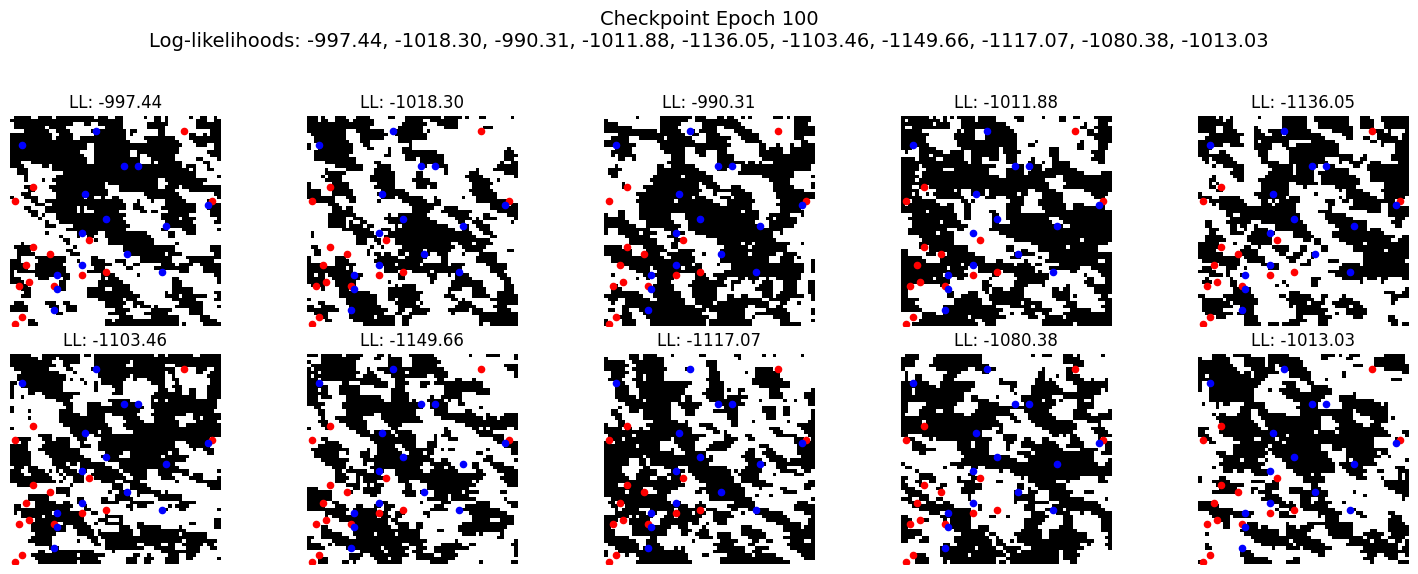

Loading checkpoint: ./vision_transformer_patch4x4_epoch200.pth


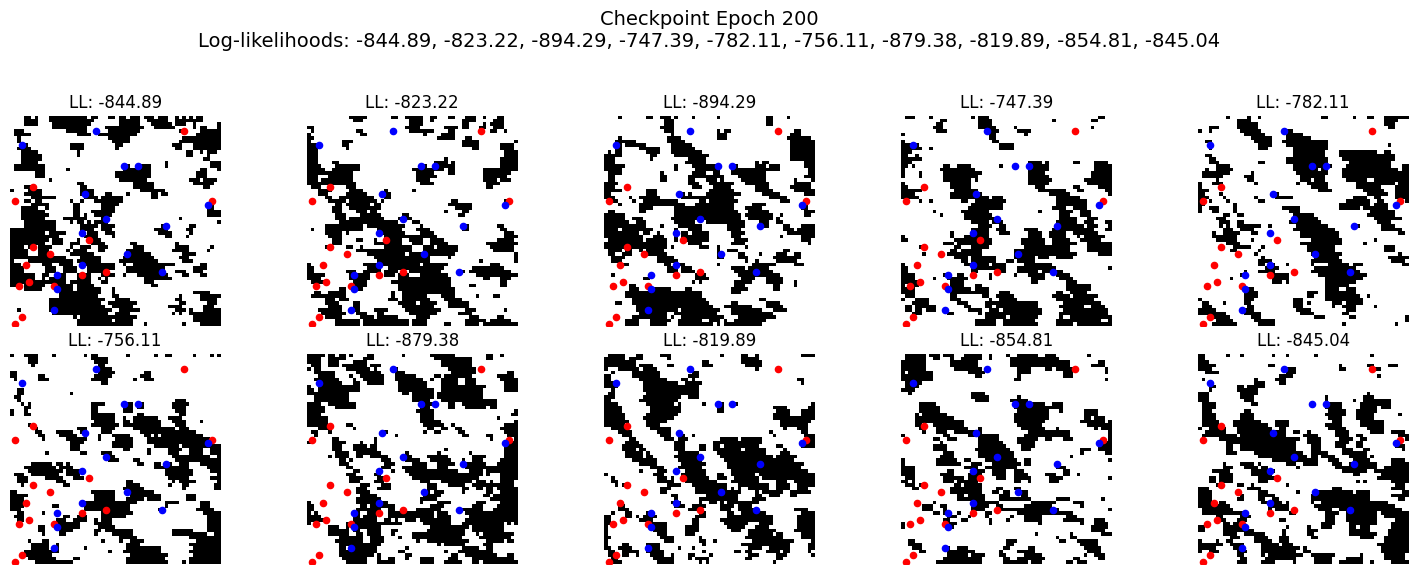

Loading checkpoint: ./vision_transformer_patch4x4_epoch300.pth


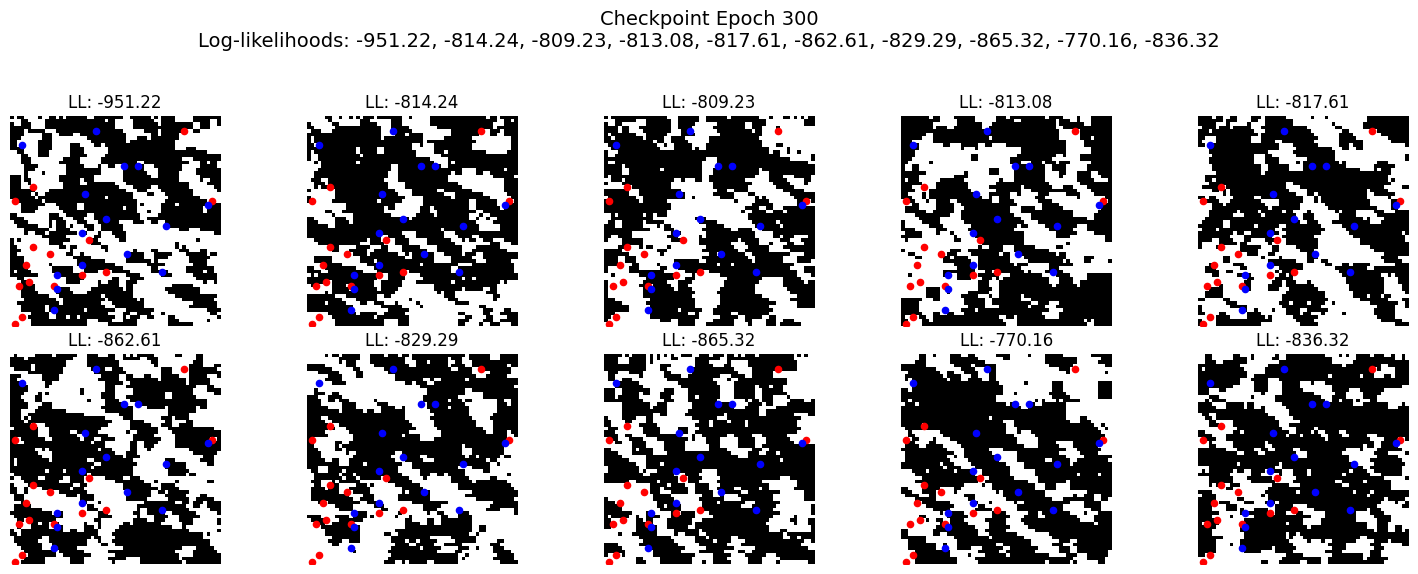

Loading checkpoint: ./vision_transformer_patch4x4_epoch400.pth


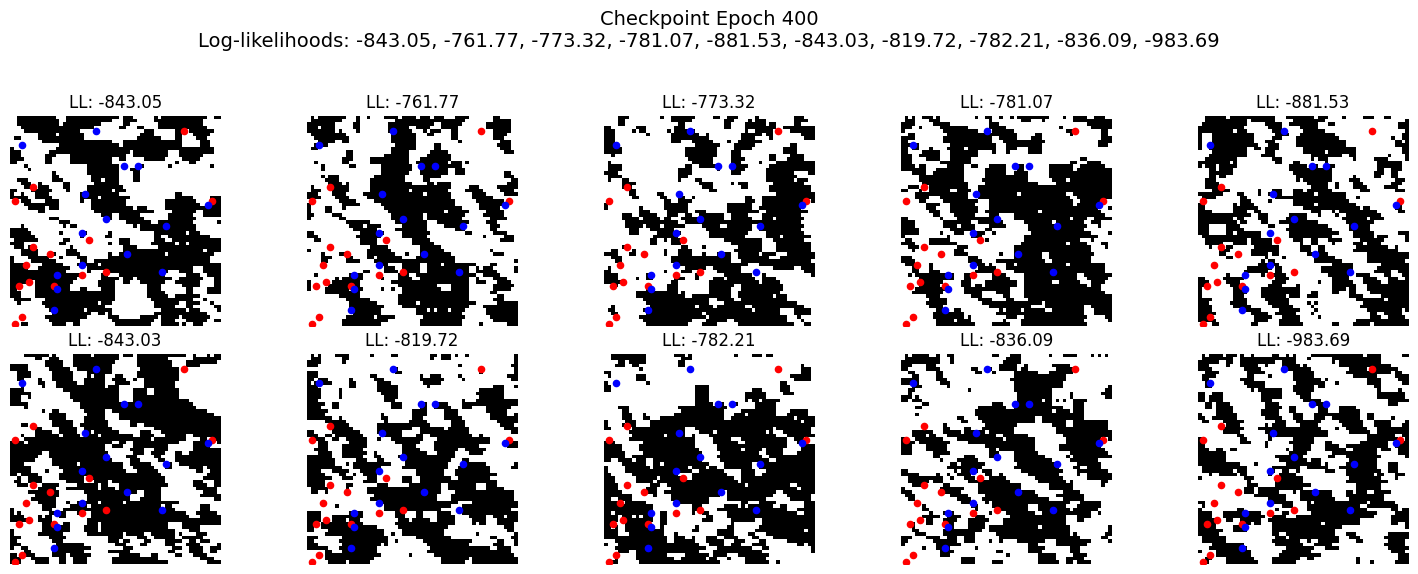

Loading checkpoint: ./vision_transformer_patch4x4_epoch500.pth


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Assumed to be defined in your training code:
# - VisionTransformer
# - TransformerEncoderLayer
# - patch_to_int
# - sample_image_conditional
# - BinaryImageDataset with patches_to_image() method

# Parameters.
patch_size = 4
image_size = 60

# Provided condition values (global pixel indices on a flattened 60x60 image)
condition_indices = np.array([876,2825,2122,2892,1556,2683,2667,1767,483,2351,2000,
                                3312,2953,289,2373,2720,872,2713,1206,1341,3541,
                                2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                               1,1,1,0,1,0,1,1,0,1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model architecture using the same hyperparameters as in training.
num_heads = 8
num_layers = 8
ffn_dim = 1024
hidden_dim = 256
dropout = 0.1

model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout)

# IMPORTANT: Load the vocabulary saved during training.
# For example, if during training you did:
#   torch.save(model.vocab, "vocab.pt")
vocab = model.build_vocabulary(training_data, patch_size)
model.vocab = vocab.to(device)
# Recompute the integer encoding for the vocabulary.
model.vocab_int = patch_to_int(model.vocab).to(device)
# Rebuild the output projection to match the vocab size.
model.output_projection = nn.Linear(model.hidden_dim, model.vocab.size(0)).to(device)
model = model.to(device)

# List of checkpoint epochs.
checkpoint_epochs = list(range(100, 1001, 100))
checkpoint_dir = "./"  # Adjust if needed

for epoch in checkpoint_epochs:
    ckpt_path = f"{checkpoint_dir}vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch}.pth"
    print(f"Loading checkpoint: {ckpt_path}")
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    samples = []
    ll_values = []
    # Generate 10 conditional samples.
    for i in range(10):
        # sample_image_conditional is assumed to use your conditional sampling procedure.
        generated, ll = sample_image_conditional(model, patch_size, image_size,
                                                 temperature=1.0,
                                                 condition_indices=condition_indices,
                                                 condition_values=condition_values)
        # Convert the generated patches back to a 60x60 image.
        gen_img = BinaryImageDataset.patches_to_image(generated[0], patch_size, image_size)
        samples.append(gen_img)
        ll_values.append(ll)

    # For each generated image, extract the pixel values at the given condition indices.
    # Convert condition indices (global 60x60) to x,y coordinates.
    x_coords = condition_indices % image_size
    y_coords = condition_indices // image_size

    # Plot the 10 realizations in a 2x5 grid with scatter overlay.
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Checkpoint Epoch {epoch}\nLog-likelihoods: " +
                 ", ".join(f"{ll:.2f}" for ll in ll_values), fontsize=14)
    for ax, img, ll_val in zip(axes.flat, samples, ll_values):
        # Convert image to numpy array on CPU.
        img_np = img.cpu().numpy()
        ax.imshow(img_np, cmap='gray', vmin=0, vmax=1)
        # Extract the generated condition values at the specified indices.
        gen_cond_vals = img_np[y_coords, x_coords]  # note: indexing rows then columns
        # Define colors based on the generated pixel values: red for 1, blue for 0.
        # (Assuming binary images where values are 0 or 1.)
        red_mask = gen_cond_vals == 1
        blue_mask = gen_cond_vals == 0
        ax.scatter(x_coords[red_mask], y_coords[red_mask], color='red', marker='o', s=20)
        ax.scatter(x_coords[blue_mask], y_coords[blue_mask], color='blue', marker='o', s=20)
        ax.set_title(f"LL: {ll_val:.2f}")
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Claude 3.7 Sonnet Thinking approach

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import math

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Helper: Image sampling with improvements
########################################

def sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                            condition_indices=None, condition_values=None,
                            top_k=40, adaptive_temp=True):
    """
    Generate one image using the autoregressive model while enforcing conditions.

    Args:
        model: The trained VisionTransformer model
        patch_size: Size of each patch (e.g., 3 for 3x3 patches)
        image_size: Size of the image (e.g., 60 for 60x60 images)
        temperature: Base temperature for sampling (higher = more diverse)
        condition_indices: numpy array of global pixel indices (from a flattened image)
        condition_values: numpy array of binary values corresponding to these indices
        top_k: If > 0, use top-k filtering to prevent low-probability tokens
        adaptive_temp: If True, decrease temperature as generation progresses

    Returns: (generated, log_likelihood)
      - generated: a tensor of shape (1, num_patches, patch_dim)
      - log_likelihood: the sum of log-probabilities for each patch token
    """
    num_patches = (image_size // patch_size) ** 2
    patch_dim = patch_size * patch_size

    # Initialize generated patches with the model's mask token
    generated = model.mask_token.detach().clone().unsqueeze(0).repeat(num_patches, 1)  # (num_patches, patch_dim)
    log_likelihood = 0.0

    # Pre-compute patch-level conditions
    patch_conditions = {}
    if condition_indices is not None and condition_values is not None:
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            # Convert global pixel index to (row, col)
            global_row = int(cond_idx) // image_size
            global_col = int(cond_idx) % image_size
            # Determine which patch this falls into
            patch_row = global_row // patch_size
            patch_col = global_col // patch_size
            num_patches_per_row = image_size // patch_size
            patch_index = patch_row * num_patches_per_row + patch_col
            # Determine local index within the patch
            local_row = global_row % patch_size
            local_col = global_col % patch_size
            local_index = local_row * patch_size + local_col
            if patch_index not in patch_conditions:
                patch_conditions[patch_index] = {}
            patch_conditions[patch_index][local_index] = float(cond_val)

    generated = generated.unsqueeze(0)  # shape: (1, num_patches, patch_dim)

    # Track generation time
    start_time = time.time()

    # Sequentially generate patch tokens in raster-scan order
    for i in range(num_patches):
        # If conditions exist for this patch, get them
        cond = patch_conditions.get(i, None)

        # Forward pass: compute logits for the entire sequence
        with torch.no_grad(), autocast():
            logits = model(generated)  # shape: (1, num_patches, vocab_size)
            logits_i = logits[0, i]  # (vocab_size,)

            # Apply adaptive temperature scaling if enabled
            if adaptive_temp:
                # Start high, gradually reduce (diversity → quality)
                current_temp = temperature * (1.0 - 0.3 * (i / num_patches))
            else:
                current_temp = temperature

            logits_i = logits_i / current_temp

            # Apply top-k filtering
            if top_k > 0 and top_k < model.vocab_size:
                values, _ = torch.topk(logits_i, top_k)
                min_value = values[-1]
                logits_i = torch.where(logits_i < min_value,
                                      torch.full_like(logits_i, -float('inf')),
                                      logits_i)

        if cond is not None:
            # For each conditioned local pixel, restrict the distribution
            candidate_mask = torch.ones(model.vocab_size, dtype=torch.bool, device=logits_i.device)
            for local_idx, cond_val in cond.items():
                # For each token, check if its value at local_idx matches the condition
                candidate_mask = candidate_mask & (model.vocab[:, local_idx] == cond_val)
            logits_i = logits_i.masked_fill(~candidate_mask, -1e9)

        probs = torch.softmax(logits_i, dim=-1)
        token = torch.multinomial(probs, num_samples=1)

        # Accumulate log probability
        log_prob = torch.log(probs[token] + 1e-10)  # add epsilon for stability
        log_likelihood += log_prob.item()

        # Lookup the corresponding patch token from the vocabulary
        patch = model.vocab[token]
        generated[0, i] = patch

    generation_time = time.time() - start_time
    print(f"Generation completed in {generation_time:.2f}s for {num_patches} patches")

    return generated, log_likelihood

def generate_diverse_samples(model, patch_size, image_size, condition_indices=None,
                            condition_values=None, num_samples=3, base_temp=1.0):
    """
    Generate multiple diverse samples with the same conditions but different temperatures
    """
    samples = []
    log_probs = []

    # Generate with increasing temperatures for more diversity
    temps = [base_temp * (0.8 + 0.2 * i) for i in range(num_samples)]

    for i, temp in enumerate(temps):
        print(f"Generating sample {i+1}/{num_samples} with temperature {temp:.2f}")
        gen, ll = sample_image_conditional(
            model, patch_size, image_size,
            temperature=temp,
            condition_indices=condition_indices,
            condition_values=condition_values,
            top_k=40,  # Use top-k filtering
            adaptive_temp=True  # Use adaptive temperature
        )
        samples.append(gen)
        log_probs.append(ll)

    return samples, log_probs

########################################
# Improved Vision Transformer Components
########################################

class StochasticDepth(nn.Module):
    """
    Implements Stochastic Depth: randomly drops entire layers during training
    for regularization, similar to dropout but on a layer level.
    """
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, device=x.device)
        random_tensor = random_tensor.floor() / keep_prob
        return x * random_tensor

class ImprovedTransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1, drop_path=0.0):
        super().__init__()
        # Pre-norm architecture
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Multi-head attention
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

        # Expanded feed-forward network (wider for better capacity)
        expansion_factor = 4  # Standard is 4x in modern transformers
        self.linear1 = nn.Linear(hidden_dim, ffn_dim * expansion_factor)
        self.linear2 = nn.Linear(ffn_dim * expansion_factor, hidden_dim)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

        # Stochastic depth for regularization
        self.drop_path = StochasticDepth(drop_path)

    def forward(self, z, attn_mask=None):
        # Pre-norm architecture (more stable training)
        z_norm = self.norm1(z)

        # Self-attention with proper masking handling
        if attn_mask is not None:
            # Convert boolean mask to float attention mask
            if attn_mask.dtype == torch.bool:
                attn_mask = attn_mask.float().masked_fill(
                    ~attn_mask, float("-inf")).masked_fill(attn_mask, float(0.0))

            attn_output, _ = self.self_attn(z_norm, z_norm, z_norm, attn_mask=attn_mask)
        else:
            attn_output, _ = self.self_attn(z_norm, z_norm, z_norm)

        # Apply residual connection with potential stochastic depth
        z = z + self.drop_path(self.dropout1(attn_output))

        # Feed-forward block also with pre-norm
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))

        # Second residual connection
        z = z + self.drop_path(self.dropout2(ff_output))
        return z

class ImprovedVisionTransformer(nn.Module):
    """Enhanced Vision Transformer with improved architecture and training stability"""
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Stochastic depth with increasing probability by depth
        dpr = [x.item() for x in torch.linspace(0, 0.2, num_layers)]

        # Improved transformer layers
        self.transformer_layers = nn.ModuleList([
            ImprovedTransformerEncoderLayer(
                hidden_dim, num_heads, ffn_dim, dropout, drop_path=dpr[i]
            ) for i in range(num_layers)
        ])

        self.dropout_layer = nn.Dropout(dropout)

        # Final layer norm (following modern architectures)
        self.norm = nn.LayerNorm(hidden_dim)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size

        # Assuming training_data shape is (N, H, W)
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)

        # Extract non-overlapping patches using unfold (vectorized)
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                      .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)

        # Build vocabulary with a progress bar
        unique_set = set()
        unique_list = []

        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}",
                      total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()  # force on CPU for uniqueness checking
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)

        print(f"Found {len(unique_list)} unique patch patterns")

        # Add full mask token (a patch filled with 0.5)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))

        # Add one-mask tokens for each patch dimension
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)

                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)

        self.vocab = torch.stack(unique_list)  # shape: (vocab_size, patch_dim)
        self.vocab_size = self.vocab.size(0)

        # Precompute integer encoding for vocabulary tokens (for faster matching)
        self.vocab_int = patch_to_int(self.vocab)

        # Embedding projection: from patch_dim to hidden_dim
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)

        # Output projection: from hidden_dim to vocab size (to yield logits)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)

        # Learned positional encoding for the number of patches (with proper initialization)
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))

        # Learnable mask token
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))

        # Initialize weights
        self._init_weights()

        return self.vocab

    def _init_weights(self):
        """
        Initialize weights properly for transformer with improved stability
        """
        # Initialize embeddings
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)

        # Initialize projection layers
        if hasattr(self, 'embedding_projection'):
            nn.init.trunc_normal_(self.embedding_projection.weight, std=0.02)
            if self.embedding_projection.bias is not None:
                nn.init.zeros_(self.embedding_projection.bias)

        if hasattr(self, 'output_projection'):
            nn.init.trunc_normal_(self.output_projection.weight, std=0.02)
            if self.output_projection.bias is not None:
                nn.init.zeros_(self.output_projection.bias)

        # Initialize mask token
        if hasattr(self, 'mask_token'):
            nn.init.normal_(self.mask_token, mean=0.5, std=0.01)

    def forward(self, patches, attn_mask=None):
        # patches shape: (batch_size, num_patches, patch_dim)
        batch_size, num_patches, _ = patches.shape

        # Convert patches to vector embeddings
        embeddings = self.embedding_projection(patches)

        # Add positional encoding
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]

        # Apply dropout
        z = self.dropout_layer(embeddings)

        # Pass through transformer encoder layers
        for layer in self.transformer_layers:
            z = layer(z, attn_mask=attn_mask)

        # Apply final layer norm
        z = self.norm(z)

        # Project to vocabulary space
        logits = self.output_projection(z)  # shape: (batch_size, num_patches, vocab_size)

        return logits

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # shape: (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def batch_to_patches(images, patch_size):
        """Vectorized patch extraction for a batch"""
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches

    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        """Convert patches to image (assumes patch order is in raster scan)"""
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Vectorized Target Computation
########################################

def compute_targets_vectorized(patches, vocab, vocab_int=None):
    """
    Efficiently compute closest vocabulary token targets for all patches

    Args:
        patches: Tensor of shape [batch, num_patches, patch_dim] or [num_patches, patch_dim]
        vocab: Vocabulary tensor of shape [vocab_size, patch_dim]
        vocab_int: Optional precomputed integer codes for vocab (for binary data)

    Returns:
        targets: Long tensor of target indices with shape matching patches batch dims + []
    """
    # Handle both single image and batch cases
    orig_shape = patches.shape[:-1]  # Original batch dimensions

    # Reshape to 2D: [num_total_patches, patch_dim]
    if patches.dim() > 2:
        patches_flat = patches.reshape(-1, patches.shape[-1])
    else:
        patches_flat = patches

    # For binary data, use integer encoding for exact matching (much faster)
    if vocab_int is not None:
        # Convert patches to integer codes
        patch_codes = patch_to_int(patches_flat)

        # Initialize targets tensor
        targets_flat = torch.zeros(patches_flat.shape[0], dtype=torch.long, device=patches.device)

        # Match each patch to closest vocab token by matching integer codes
        # This is faster than computing distances for binary data
        for i, code in enumerate(patch_codes):
            # Find matching vocab entry
            matches = (vocab_int == code)
            if matches.any():
                # If exact match found, use it
                targets_flat[i] = matches.nonzero(as_tuple=True)[0][0]
            else:
                # If no exact match (shouldn't happen with binary data), fall back to L2
                distances = torch.sum((vocab - patches_flat[i:i+1]) ** 2, dim=1)
                targets_flat[i] = torch.argmin(distances)
    else:
        # For non-binary data or if vocab_int not provided, use L2 distance
        # Compute all pairwise distances using efficient cdist
        distances = torch.cdist(patches_flat, vocab)
        targets_flat = torch.argmin(distances, dim=1)

    # Reshape back to original batch dimensions
    targets = targets_flat.reshape(orig_shape)

    return targets

########################################
# Training Pipeline with All Improvements
########################################

def train_improved_model(patch_size, training_data, num_epochs=1000, batch_size=64,
                         eval_every=20, save_every=100):
    """
    Training pipeline with all the suggested improvements
    """
    # Enhanced hyperparameters
    num_heads = 8
    num_layers = 6
    ffn_dim = 512
    hidden_dim = 192  # Increased from 128

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Keep training data on CPU until needed
    image_size = training_data.shape[1]  # assume square images

    # Initialize wandb run with detailed config
    wandb.init(
        project="improved-vision-transformer",
        config={
            "architecture": "ImprovedVisionTransformer",
            "num_heads": num_heads,
            "num_layers": num_layers,
            "ffn_dim": ffn_dim,
            "hidden_dim": hidden_dim,
            "patch_size": patch_size,
            "num_epochs": num_epochs,
            "batch_size": batch_size,
            "optimizer": "AdamW",
            "weight_decay": 0.01,
            "learning_rate": 0.001,
            "scheduler": "CosineAnnealing",
            "mixed_precision": True,
            "stochastic_depth": True,
        },
        name=f"improved_patch_{patch_size}x{patch_size}"
    )

    # Build improved model
    model = ImprovedVisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1)

    # Build vocabulary (using CPU data)
    print("Building vocabulary...")
    model.build_vocabulary(training_data, patch_size)

    # Move model to device after building vocabulary
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = model.vocab_int.to(device)

    # Improved optimizer: AdamW with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01, betas=(0.9, 0.999))

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Dataset and optimized DataLoader
    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )

    # Setup mixed precision training
    scaler = GradScaler()

    # Training metrics tracking
    best_loss = float('inf')

    # Global step for wandb logging
    global_step = 0

    # Track training time
    total_training_time = 0

    # Training loop
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        total_loss = 0.0

        # Progressive masking curriculum instead of random
        # Start with low masking rate, gradually increase
        mask_rate = min(0.85, 0.15 + (0.7 * epoch / (num_epochs * 0.8)))
        partial_mask_rate = 0.3  # 30% of masked patches will be partial

        # Create progress bar
        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})")

        # Pre-compute mask tokens for efficiency
        full_mask_token = model.mask_token.clone().detach()

        batch_times = []

        for batch_idx, batch in enumerate(epoch_bar):
            batch_start = time.time()

            # Move batch to GPU
            batch = batch.to(device, non_blocking=True)
            B = batch.shape[0]

            # Convert to patches (single operation)
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)
            num_patches = patches.shape[1]
            patch_dim = patches.shape[2]

            # Create mask: for each patch in each image, mask with probability = mask_rate
            mask = torch.rand(B, num_patches, device=device) < mask_rate

            # Ensure at least one masked patch per sample
            for i in range(B):
                if not torch.any(mask[i]):
                    random_idx = torch.randint(0, num_patches, (1,), device=device)
                    mask[i, random_idx] = True

            # Decide which masked patches are partial vs. full (vectorized)
            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            # Create masked patches efficiently
            masked_patches = patches.clone()

            # Apply full masks (vectorized)
            if full.any():
                # Extract indices where full masking applies
                full_indices = torch.nonzero(full, as_tuple=True)
                masked_patches[full_indices] = full_mask_token

            # Apply partial masks
            if partial.any():
                # Get indices where partial masking applies
                partial_idx = torch.nonzero(partial, as_tuple=True)
                num_partial = len(partial_idx[0])

                # Create new patches with a single observed value
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)

                # Extract original values at random positions
                orig_vals = patches[partial_idx[0], partial_idx[1], :].gather(
                    1, rand_positions.unsqueeze(1)).squeeze(1)

                # Update new patches with observed values
                new_patches[torch.arange(num_partial, device=device), rand_positions] = orig_vals

                # Update masked patches
                masked_patches[partial_idx] = new_patches

            # Mixed precision forward pass
            with autocast():
                # Get model predictions
                logits = model(masked_patches)  # shape: (B, num_patches, vocab_size)

                # Compute targets efficiently
                targets = compute_targets_vectorized(patches, model.vocab, model.vocab_int)

                # Compute loss over all patches (or only masked ones)
                # Option 1: Loss only on masked patches
                masked_logits = logits.reshape(-1, model.vocab_size)[mask.reshape(-1)]
                masked_targets = targets.reshape(-1)[mask.reshape(-1)]
                loss = criterion(masked_logits, masked_targets)

                # Option 2: Full loss with masked patches weighted more
                # full_loss = criterion(logits.reshape(-1, model.vocab_size), targets.reshape(-1))
                # masked_loss = criterion(masked_logits, masked_targets)
                # loss = 0.3 * full_loss + 0.7 * masked_loss

            # Backward and optimize with mixed precision
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            scaler.scale(loss).backward()

            # Optional: gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            # Track metrics
            total_loss += loss.item()
            batch_time = time.time() - batch_start
            batch_times.append(batch_time)

            # Update progress bar
            avg_batch_time = sum(batch_times[-10:]) / min(len(batch_times), 10)
            epoch_bar.set_postfix(
                loss=f"{loss.item():.4f}",
                mask_rate=f"{mask_rate:.2f}",
                batch_time=f"{avg_batch_time:.3f}s"
            )

            # Update global step
            global_step += 1

            # Visualize first batch of each epoch
            if batch_idx == 0:
                visualize_step = epoch * 10000  # Separate step space for visualization

                # Generate visualization
                with torch.no_grad(), autocast():
                    model.eval()

                    # Keep track of original, masked and reconstructed images
                    orig_img = batch[0].cpu()
                    masked_img = BinaryImageDataset.patches_to_image(
                        masked_patches[0], patch_size, image_size).cpu()

                    # Generate reconstructed image
                    recon_patches = masked_patches[0:1].clone()

                    # For masked patches, predict the most likely token
                    for p in range(num_patches):
                        if mask[0, p]:
                            # Forward pass for just this batch
                            patch_logits = model(recon_patches)
                            # Get the most likely token
                            patch_idx = torch.argmax(patch_logits[0, p])
                            # Replace with predicted token
                            recon_patches[0, p] = model.vocab[patch_idx]

                    # Convert to image
                    recon_img = BinaryImageDataset.patches_to_image(
                        recon_patches[0], patch_size, image_size).cpu()

                    # Log to wandb
                    wandb.log({
                        "visualization/original": wandb.Image(orig_img),
                        "visualization/masked": wandb.Image(masked_img),
                        "visualization/reconstructed": wandb.Image(recon_img)
                    }, step=visualize_step)

                    # Return to training mode
                    model.train()

        # End of epoch processing
        epoch_time = time.time() - epoch_start
        total_training_time += epoch_time
        avg_loss = total_loss / len(dataloader)

        # Step the learning rate scheduler
        scheduler.step()

        # Log metrics
        wandb.log({
            "training/epoch": epoch,
            "training/loss": avg_loss,
            "training/mask_rate": mask_rate,
            "training/learning_rate": scheduler.get_last_lr()[0],
            "training/epoch_time": epoch_time,
            "training/total_training_time": total_training_time
        }, step=global_step)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.6f}, Time: {epoch_time:.2f}s")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_loss,
            }, f"improved_vit_patch{patch_size}x{patch_size}_best.pth")

            wandb.run.summary["best_loss"] = best_loss
            wandb.run.summary["best_epoch"] = epoch

        # Periodic evaluation
        if (epoch + 1) % eval_every == 0 or epoch == num_epochs - 1:
            model.eval()
            # Basic evaluation on a batch from the training set
            with torch.no_grad(), autocast():
                eval_batch = next(iter(dataloader)).to(device)
                eval_patches = BinaryImageDataset.batch_to_patches(eval_batch, patch_size)

                # Mask 50% of patches
                eval_mask = torch.rand(eval_batch.size(0), num_patches, device=device) < 0.5
                eval_masked = eval_patches.clone()
                eval_masked[eval_mask] = model.mask_token

                # Forward pass
                eval_logits = model(eval_masked)

                # Compute targets
                eval_targets = compute_targets_vectorized(eval_patches, model.vocab, model.vocab_int)

                # Compute accuracy (on masked patches only)
                masked_preds = torch.argmax(eval_logits[eval_mask], dim=1)
                masked_targets = eval_targets[eval_mask]
                accuracy = (masked_preds == masked_targets).float().mean().item()

                # Log eval metrics
                wandb.log({
                    "eval/accuracy": accuracy,
                }, step=global_step)

                print(f"Eval accuracy: {accuracy:.4f}")

        # Save checkpoint periodically
        if (epoch + 1) % save_every == 0 or epoch == num_epochs - 1:
            checkpoint_path = f"improved_vit_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
                'best_loss': best_loss,
            }, checkpoint_path)

            # Generate conditional samples
            generate_conditional_samples(model, patch_size, image_size, device, global_step)

    # Final evaluation
    print("Training completed!")
    print(f"Best loss: {best_loss:.4f}")
    print(f"Total training time: {total_training_time:.2f}s")

    # Save final model
    torch.save(model.state_dict(), f"improved_vit_patch{patch_size}x{patch_size}_final.pth")

    # Finish wandb run
    wandb.finish()

    return model

def generate_conditional_samples(model, patch_size, image_size, device, step):
    """Generate and log conditional samples with the model"""
    model.eval()

    # Provided condition indices and values (global indices for a 60x60 image)
    condition_indices = np.array([876,2825,2122,2892,1556,2683,2667,1767,483,2351,2000,3312,2953,289,
                                  2373,2720,872,2713,1206,1341,3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
    condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])

    # Create condition visualization
    cond_img = torch.zeros(image_size, image_size, device=device)
    for idx, val in zip(condition_indices, condition_values):
        row = idx // image_size
        col = idx % image_size
        cond_img[row, col] = val

    with torch.no_grad():
        # Generate diverse samples
        samples, log_likes = generate_diverse_samples(
            model, patch_size, image_size,
            condition_indices=condition_indices,
            condition_values=condition_values,
            num_samples=3
        )

        # Create figure with condition points and samples
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Plot condition points
        axes[0].imshow(cond_img.cpu(), cmap='gray')
        axes[0].set_title("Condition Points")

        # Plot samples with different temperatures
        for i, (sample, ll) in enumerate(zip(samples, log_likes)):
            # Convert sample patches to image
            sample_img = BinaryImageDataset.patches_to_image(
                sample[0], patch_size, image_size)

            # Display
            axes[i+1].imshow(sample_img.cpu(), cmap='gray')
            axes[i+1].set_title(f"Sample {i+1}, LL: {ll:.2f}")

        # Save figure to wandb
        wandb.log({
            "conditional_generation/samples": wandb.Image(fig)
        }, step=step)
        plt.close(fig)

########################################
# Main Entry Point
########################################

def main():
    # Load and preprocess training data
    print("Loading training data...")
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    # Reshape to 60x60 images
    training_data = training_data.reshape(-1, 64, 64)[:, :60, :60]
    print(f"Training data shape: {training_data.shape}")

    # Convert to PyTorch tensor (keep on CPU initially)
    training_data = torch.tensor(training_data, dtype=torch.float32)

    # Train the model with optimized pipeline
    patch_size = 3  # 3x3 patches offer good balance for 60x60 binary images
    model = train_improved_model(
        patch_size=patch_size,
        training_data=training_data,
        num_epochs=1000,
        batch_size=64,
        eval_every=20,
        save_every=100
    )

    return model

if __name__ == "__main__":
    main()

Loading training data...
Training data shape: (9000, 60, 60)
Using device: cuda
Building vocabulary...


Building Vocabulary for 3x3: 100%|██████████| 3600000/3600000 [00:14<00:00, 253909.77it/s]
<ipython-input-14-44497637417b>:530: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Found 512 unique patch patterns


Epoch 1/1000 (patch 3x3):   0%|          | 0/141 [00:00<?, ?it/s]<ipython-input-14-44497637417b>:615: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/1000 (patch 3x3):   0%|          | 0/141 [00:03<?, ?it/s, batch_time=3.203s, loss=6.3101, mask_rate=0.15]<ipython-input-14-44497637417b>:665: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 1/1000 (patch 3x3):   6%|▋         | 9/141 [00:27<06:48,  3.10s/it, batch_time=2.851s, loss=4.1769, mask_rate=0.15]


KeyboardInterrupt: 

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import multiprocessing

########################################
# Vision Transformer and Vocabulary
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        # Assuming training_data shape is (N, H, W)
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)

        # Extract non-overlapping patches using unfold.
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)

        # Build vocabulary with a progress bar.
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()  # force on CPU for uniqueness checking
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        # Add full mask token (a patch filled with 0.5)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        # Add one-mask tokens for each patch dimension.
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)

        self.vocab = torch.stack(unique_list)
        self.vocab_size = self.vocab.size(0)
        # Set up the embedding projection (from patch_dim to hidden_dim)
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        # Output projection: from hidden_dim to vocab size (to yield logits)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        # Learned positional encoding for the number of patches.
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        return self.vocab

    def forward(self, patches):
        # patches shape: (batch_size, num_patches, patch_dim)
        batch_size, num_patches, _ = patches.shape
        # Step 7: convert patches to vector embeddings
        embeddings = self.embedding_projection(patches)
        # Step 8: add positional encoding
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        # Step 9: pass through transformer encoder layers
        for layer in self.transformer_layers:
            z = layer(z)
        # Step 10: project context vectors to (batch, num_patches, vocab_size)
        logits = self.output_projection(z)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        # Self-attention block with residual connection.
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        # Feed-forward block with residual connection.
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # images shape: (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def batch_to_patches(images, patch_size):
        # Vectorized patch extraction for a batch (images shape: (B, H, W))
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches

    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # Reconstruct an image from a list of patches.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Training Function for a Given Patch Size
########################################

def train_model_for_patch(patch_size, training_data, num_epochs=1000, batch_size=64):
    # Common hyperparameters.
    num_heads = 8
    num_layers = 6
    ffn_dim = 512
    hidden_dim = 128

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]  # assume square images

    # Initialize a unique wandb run so that runs can be compared side by side.
    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "num_epochs": num_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}",
               reinit=True)

    # Create the model and build its vocabulary.
    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Step 4: Increase mask rate linearly from a very small value (ensuring at least one mask) to 1.
        mask_rate = (epoch + 1) / num_epochs  # fraction of patches to mask
        partial_mask_rate = 0.3  # 30% of masked patches will be partial

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            # Step 5: Convert the batch to patches.
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)
            num_patches = patches.shape[1]
            patch_dim = patches.shape[2]

            # Step 6: Determine which patches to mask.
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            mask[:, 0] = True  # Ensure at least one masked patch per sample

            # Decide which masks are partial (30%) and which are full.
            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            # For full masks, use the full mask token (last token in vocab).
            if full.any():
                masked_patches[full] = model.vocab[-1]
            # For partial masks, fill with 0.5 and restore one randomly chosen element.
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Steps 7–10: Forward pass
            logits = model(masked_patches)  # logits shape: (B, num_patches, vocab_size)

            # Step 11–12: Compute the target token for each patch and select only masked patches.
            all_patches = patches.view(B * num_patches, patch_dim)
            vocab = model.vocab  # (vocab_size, patch_dim)
            dists = torch.cdist(all_patches, vocab, p=2) ** 2  # squared Euclidean distances
            targets_all = torch.argmin(dists, dim=1).view(B, num_patches)
            masked_targets = targets_all[mask]

            loss = criterion(logits[mask], masked_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)

        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # Save a checkpoint every 100 epochs.
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")

    wandb.finish()
    return model

########################################
# Main: Train All Models
########################################

if __name__ == "__main__":
    # Load training data (assumed shape: (9000, 60, 60) after reshaping)
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    # Reshape to 60x60 images (adjust if needed)
    training_data = training_data.reshape(-1, 64, 64)[:, :60, :60]
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)

    # Train models for patch sizes 2x2, 3x3, and 4x4 using the same parameters.
    patch_sizes = [2, 3, 4]
    models = {}
    for ps in patch_sizes:
        print(f"\nTraining model for patch size {ps}x{ps}")
        models[ps] = train_model_for_patch(ps, training_data)

    # With wandb, the runs will appear side by side in your project dashboard.

Training data shape: (9000, 60, 60)

Training model for patch size 2x2


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import multiprocessing

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Vision Transformer and Vocabulary
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        # Assuming training_data shape is (N, H, W)
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)

        # Extract non-overlapping patches using unfold.
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)

        # Build vocabulary with a progress bar.
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()  # force on CPU for uniqueness checking
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        # Add full mask token (a patch filled with 0.5) to the vocabulary if desired.
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        # Add one-mask tokens for each patch dimension.
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)

        self.vocab = torch.stack(unique_list)
        self.vocab_size = self.vocab.size(0)
        # Precompute integer encoding for vocabulary tokens.
        self.vocab_int = patch_to_int(self.vocab)
        # Set up the embedding projection (from patch_dim to hidden_dim)
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        # Output projection: from hidden_dim to vocab size (to yield logits)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        # Learned positional encoding for the number of patches.
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        # --- Learnable Mask Token ---
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))
        return self.vocab

    def forward(self, patches):
        # patches shape: (batch_size, num_patches, patch_dim)
        batch_size, num_patches, _ = patches.shape
        # Convert patches to vector embeddings.
        embeddings = self.embedding_projection(patches)
        # Add positional encoding.
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        # Pass through transformer encoder layers.
        for layer in self.transformer_layers:
            z = layer(z)
        # Project context vectors to (batch, num_patches, vocab_size)
        logits = self.output_projection(z)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        # Self-attention block with residual connection.
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        # Feed-forward block with residual connection.
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # images shape: (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def batch_to_patches(images, patch_size):
        # Vectorized patch extraction for a batch (images shape: (B, H, W))
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches

    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # Reconstruct an image from a list of patches.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Training Function for a Given Patch Size
########################################

def train_model_for_patch(patch_size, training_data, num_epochs=1000, batch_size=64):
    # Common hyperparameters.
    num_heads = 8
    num_layers = 6
    ffn_dim = 512
    hidden_dim = 256

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]  # assume square images

    # Initialize a unique wandb run for side-by-side comparison.
    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "num_epochs": num_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}",
               reinit=True)

    # Create the model and build its vocabulary.
    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = patch_to_int(model.vocab).to(device)  # Precompute vocab codes

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # --- Random Mask Schedule ---
        # For each epoch, sample a random mask rate between 10% and 100%.
        mask_rate = np.random.uniform(0.1, 1.0)
        partial_mask_rate = 0.3  # 30% of masked patches will be partial

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            # Convert the batch to patches.
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)
            num_patches = patches.shape[1]
            patch_dim = patches.shape[2]

            # Determine which patches to mask using the random mask rate.
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            mask[:, 0] = True  # Ensure at least one masked patch per sample

            # Decide which masked patches are partial vs. full.
            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            # For full masks, use the learnable mask token.
            if full.any():
                masked_patches[full] = model.mask_token
            # For partial masks, fill with 0.5 and restore one randomly chosen element.
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Forward pass: get logits (shape: [B, num_patches, vocab_size]).
            logits = model(masked_patches)

            # --- Full Target Computation ---
            # Compute integer codes for every original patch.
            all_patches = patches.view(B * num_patches, patch_dim)
            codes = patch_to_int(all_patches)  # shape: (B*num_patches,)
            vocab_codes = model.vocab_int  # shape: (vocab_size,)
            mask_eq = codes.unsqueeze(1) == vocab_codes.unsqueeze(0)
            target_indices = mask_eq.float().argmax(dim=1)  # shape: (B*num_patches,)
            targets_all = target_indices.view(B, num_patches)
            # Compute loss over all patches.
            loss = criterion(logits.view(-1, model.vocab_size), targets_all.view(-1))
            # ---------------------------------

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)

        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # Save a checkpoint every 100 epochs.
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")

    wandb.finish()
    return model

########################################
# Main: Train All Models
########################################

if __name__ == "__main__":
    # Load training data (assumed shape: (9000, 60, 60) after reshaping)
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    # Reshape to 60x60 images (adjust if needed)
    training_data = training_data.reshape(-1, 64, 64)[:, :60, :60]
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)

    # Train models for patch sizes 2x2, 3x3, and 4x4 using the same parameters.
    patch_sizes = [3, 4]
    models = {}
    for ps in patch_sizes:
        print(f"\nTraining model for patch size {ps}x{ps}")
        models[ps] = train_model_for_patch(ps, training_data)

    # With wandb, the runs will appear side by side in your project dashboard.

Training data shape: (9000, 60, 60)

Training model for patch size 3x3


Building Vocabulary for 3x3: 100%|██████████| 3600000/3600000 [01:22<00:00, 43526.94it/s]


[Patch 3x3] Epoch 1/1000, Loss: 3.5374, Mask Rate: 0.79


[Patch 3x3] Epoch 2/1000, Loss: 2.7708, Mask Rate: 0.80


[Patch 3x3] Epoch 3/1000, Loss: 1.9159, Mask Rate: 0.57


[Patch 3x3] Epoch 4/1000, Loss: 1.6463, Mask Rate: 0.49


[Patch 3x3] Epoch 5/1000, Loss: 0.9271, Mask Rate: 0.28


[Patch 3x3] Epoch 6/1000, Loss: 2.7681, Mask Rate: 0.83


[Patch 3x3] Epoch 7/1000, Loss: 1.4006, Mask Rate: 0.42


[Patch 3x3] Epoch 8/1000, Loss: 3.0961, Mask Rate: 0.93


[Patch 3x3] Epoch 9/1000, Loss: 1.7360, Mask Rate: 0.52


[Patch 3x3] Epoch 10/1000, Loss: 2.1311, Mask Rate: 0.64


[Patch 3x3] Epoch 11/1000, Loss: 1.2334, Mask Rate: 0.37


[Patch 3x3] Epoch 12/1000, Loss: 2.3734, Mask Rate: 0.72


[Patch 3x3] Epoch 13/1000, Loss: 1.2521, Mask Rate: 0.38


[Patch 3x3] Epoch 14/1000, Loss: 2.1787, Mask Rate: 0.66


[Patch 3x3] Epoch 15/1000, Loss: 2.2240, Mask Rate: 0.67


[Patch 3x3] Epoch 16/1000, Loss: 1.4163, Mask Rate: 0.43


[Patch 3x3] Epoch 17/1000, Loss: 1.1280, Mask Rate: 0.35


[Patch 3x3] Epoch 18/1000, Loss: 0.7193, Mask Rate: 0.23


[Patch 3x3] Epoch 19/1000, Loss: 9.1959, Mask Rate: 0.65


[Patch 3x3] Epoch 20/1000, Loss: 3.4708, Mask Rate: 0.86


[Patch 3x3] Epoch 21/1000, Loss: 3.4526, Mask Rate: 0.93


[Patch 3x3] Epoch 22/1000, Loss: 3.1252, Mask Rate: 0.87


[Patch 3x3] Epoch 23/1000, Loss: 2.1927, Mask Rate: 0.62


[Patch 3x3] Epoch 24/1000, Loss: 2.4351, Mask Rate: 0.72


[Patch 3x3] Epoch 25/1000, Loss: 2.2617, Mask Rate: 0.67


[Patch 3x3] Epoch 26/1000, Loss: 3.4519, Mask Rate: 0.99


[Patch 3x3] Epoch 27/1000, Loss: 1.3564, Mask Rate: 0.39


[Patch 3x3] Epoch 28/1000, Loss: 3.2152, Mask Rate: 0.95


[Patch 3x3] Epoch 29/1000, Loss: 2.8952, Mask Rate: 0.88


[Patch 3x3] Epoch 30/1000, Loss: 2.4469, Mask Rate: 0.75


[Patch 3x3] Epoch 31/1000, Loss: 0.7765, Mask Rate: 0.24


[Patch 3x3] Epoch 32/1000, Loss: 0.4281, Mask Rate: 0.14


[Patch 3x3] Epoch 33/1000, Loss: 2.5819, Mask Rate: 0.81


[Patch 3x3] Epoch 34/1000, Loss: 2.9465, Mask Rate: 0.92


[Patch 3x3] Epoch 35/1000, Loss: 2.1543, Mask Rate: 0.69


[Patch 3x3] Epoch 36/1000, Loss: 2.5414, Mask Rate: 0.81


[Patch 3x3] Epoch 37/1000, Loss: 1.1537, Mask Rate: 0.38


[Patch 3x3] Epoch 38/1000, Loss: 2.0382, Mask Rate: 0.66


[Patch 3x3] Epoch 39/1000, Loss: 1.9347, Mask Rate: 0.63


[Patch 3x3] Epoch 40/1000, Loss: 2.2219, Mask Rate: 0.72


[Patch 3x3] Epoch 41/1000, Loss: 1.3868, Mask Rate: 0.46


[Patch 3x3] Epoch 42/1000, Loss: 3.0961, Mask Rate: 0.96


[Patch 3x3] Epoch 43/1000, Loss: 2.6292, Mask Rate: 0.84


[Patch 3x3] Epoch 44/1000, Loss: 0.7906, Mask Rate: 0.27


[Patch 3x3] Epoch 45/1000, Loss: 2.0880, Mask Rate: 0.68


[Patch 3x3] Epoch 46/1000, Loss: 1.8018, Mask Rate: 0.60


[Patch 3x3] Epoch 47/1000, Loss: 2.8726, Mask Rate: 0.91


[Patch 3x3] Epoch 48/1000, Loss: 1.6598, Mask Rate: 0.56


[Patch 3x3] Epoch 49/1000, Loss: 2.0836, Mask Rate: 0.69


[Patch 3x3] Epoch 50/1000, Loss: 1.4938, Mask Rate: 0.52


[Patch 3x3] Epoch 51/1000, Loss: 1.0191, Mask Rate: 0.39


[Patch 3x3] Epoch 52/1000, Loss: 1.9715, Mask Rate: 0.69


[Patch 3x3] Epoch 53/1000, Loss: 1.1141, Mask Rate: 0.43


[Patch 3x3] Epoch 54/1000, Loss: 1.4749, Mask Rate: 0.55


[Patch 3x3] Epoch 55/1000, Loss: 19.1214, Mask Rate: 0.98


[Patch 3x3] Epoch 56/1000, Loss: 2.7329, Mask Rate: 0.50


[Patch 3x3] Epoch 57/1000, Loss: 0.5388, Mask Rate: 0.13


[Patch 3x3] Epoch 58/1000, Loss: 0.3897, Mask Rate: 0.11


[Patch 3x3] Epoch 59/1000, Loss: 2.6179, Mask Rate: 0.66


[Patch 3x3] Epoch 60/1000, Loss: 3.1949, Mask Rate: 0.92


[Patch 3x3] Epoch 61/1000, Loss: 2.0741, Mask Rate: 0.64


[Patch 3x3] Epoch 62/1000, Loss: 0.5015, Mask Rate: 0.16


[Patch 3x3] Epoch 63/1000, Loss: 1.5623, Mask Rate: 0.50


[Patch 3x3] Epoch 64/1000, Loss: 1.3359, Mask Rate: 0.43


[Patch 3x3] Epoch 65/1000, Loss: 1.3598, Mask Rate: 0.45


[Patch 3x3] Epoch 66/1000, Loss: 2.9182, Mask Rate: 0.89


[Patch 3x3] Epoch 67/1000, Loss: 1.1799, Mask Rate: 0.41


[Patch 3x3] Epoch 68/1000, Loss: 3.0386, Mask Rate: 0.93


[Patch 3x3] Epoch 69/1000, Loss: 1.5361, Mask Rate: 0.53


[Patch 3x3] Epoch 70/1000, Loss: 2.3014, Mask Rate: 0.76


[Patch 3x3] Epoch 71/1000, Loss: 0.8552, Mask Rate: 0.32


[Patch 3x3] Epoch 72/1000, Loss: 1.0759, Mask Rate: 0.40


[Patch 3x3] Epoch 73/1000, Loss: 1.3598, Mask Rate: 0.49


[Patch 3x3] Epoch 74/1000, Loss: 1.0351, Mask Rate: 0.39


[Patch 3x3] Epoch 75/1000, Loss: 1.2643, Mask Rate: 0.46


[Patch 3x3] Epoch 76/1000, Loss: 5.3187, Mask Rate: 0.92


[Patch 3x3] Epoch 77/1000, Loss: 2.8289, Mask Rate: 0.88


[Patch 3x3] Epoch 78/1000, Loss: 1.7526, Mask Rate: 0.60


[Patch 3x3] Epoch 79/1000, Loss: 0.7599, Mask Rate: 0.29


[Patch 3x3] Epoch 80/1000, Loss: 0.8225, Mask Rate: 0.31


[Patch 3x3] Epoch 81/1000, Loss: 0.7773, Mask Rate: 0.30


[Patch 3x3] Epoch 82/1000, Loss: 1.2876, Mask Rate: 0.47


[Patch 3x3] Epoch 83/1000, Loss: 1.8811, Mask Rate: 0.66


[Patch 3x3] Epoch 84/1000, Loss: 1.8636, Mask Rate: 0.66


[Patch 3x3] Epoch 85/1000, Loss: 1.3846, Mask Rate: 0.51


[Patch 3x3] Epoch 86/1000, Loss: 0.5714, Mask Rate: 0.23


[Patch 3x3] Epoch 87/1000, Loss: 0.9096, Mask Rate: 0.35


[Patch 3x3] Epoch 88/1000, Loss: 2.4373, Mask Rate: 0.81


[Patch 3x3] Epoch 89/1000, Loss: 3.1512, Mask Rate: 0.98


[Patch 3x3] Epoch 90/1000, Loss: 1.0870, Mask Rate: 0.26


[Patch 3x3] Epoch 91/1000, Loss: 0.6837, Mask Rate: 0.26


[Patch 3x3] Epoch 92/1000, Loss: 0.3182, Mask Rate: 0.12


[Patch 3x3] Epoch 93/1000, Loss: 2.3078, Mask Rate: 0.70


[Patch 3x3] Epoch 94/1000, Loss: 0.6114, Mask Rate: 0.23


[Patch 3x3] Epoch 95/1000, Loss: 2.9187, Mask Rate: 0.91


[Patch 3x3] Epoch 96/1000, Loss: 0.5290, Mask Rate: 0.20


[Patch 3x3] Epoch 97/1000, Loss: 1.3419, Mask Rate: 0.49


[Patch 3x3] Epoch 98/1000, Loss: 1.9882, Mask Rate: 0.69


[Patch 3x3] Epoch 99/1000, Loss: 2.5867, Mask Rate: 0.85


[Patch 3x3] Epoch 100/1000, Loss: 1.5245, Mask Rate: 0.56


[Patch 3x3] Epoch 101/1000, Loss: 2.1008, Mask Rate: 0.73


[Patch 3x3] Epoch 102/1000, Loss: 2.1437, Mask Rate: 0.74


[Patch 3x3] Epoch 103/1000, Loss: 2.1077, Mask Rate: 0.73


[Patch 3x3] Epoch 104/1000, Loss: 3.1560, Mask Rate: 0.99


[Patch 3x3] Epoch 105/1000, Loss: 1.3789, Mask Rate: 0.51


[Patch 3x3] Epoch 106/1000, Loss: 1.5217, Mask Rate: 0.57


[Patch 3x3] Epoch 107/1000, Loss: 0.3249, Mask Rate: 0.14


[Patch 3x3] Epoch 108/1000, Loss: 2.7840, Mask Rate: 0.91


[Patch 3x3] Epoch 109/1000, Loss: 2.0678, Mask Rate: 0.73


[Patch 3x3] Epoch 110/1000, Loss: 0.7620, Mask Rate: 0.31


[Patch 3x3] Epoch 111/1000, Loss: 1.5455, Mask Rate: 0.58


[Patch 3x3] Epoch 112/1000, Loss: 2.5514, Mask Rate: 0.86


[Patch 3x3] Epoch 113/1000, Loss: 1.9188, Mask Rate: 0.69


[Patch 3x3] Epoch 114/1000, Loss: 0.9878, Mask Rate: 0.40


[Patch 3x3] Epoch 115/1000, Loss: 1.1281, Mask Rate: 0.45


[Patch 3x3] Epoch 116/1000, Loss: 1.1121, Mask Rate: 0.45


[Patch 3x3] Epoch 117/1000, Loss: 1.2507, Mask Rate: 0.50


[Patch 3x3] Epoch 118/1000, Loss: 3.0837, Mask Rate: 0.94


[Patch 3x3] Epoch 119/1000, Loss: 1.4954, Mask Rate: 0.57


[Patch 3x3] Epoch 120/1000, Loss: 0.7798, Mask Rate: 0.34


[Patch 3x3] Epoch 121/1000, Loss: 1.6005, Mask Rate: 0.61


[Patch 3x3] Epoch 122/1000, Loss: 0.3584, Mask Rate: 0.16


[Patch 3x3] Epoch 123/1000, Loss: 1.0599, Mask Rate: 0.44


[Patch 3x3] Epoch 124/1000, Loss: 2.7931, Mask Rate: 0.92


[Patch 3x3] Epoch 125/1000, Loss: 2.0048, Mask Rate: 0.73


[Patch 3x3] Epoch 126/1000, Loss: 2.8753, Mask Rate: 0.95


[Patch 3x3] Epoch 127/1000, Loss: 0.7527, Mask Rate: 0.32


[Patch 3x3] Epoch 128/1000, Loss: 2.4130, Mask Rate: 0.84


[Patch 3x3] Epoch 129/1000, Loss: 0.2426, Mask Rate: 0.11


[Patch 3x3] Epoch 130/1000, Loss: 1.8651, Mask Rate: 0.70


[Patch 3x3] Epoch 131/1000, Loss: 1.7567, Mask Rate: 0.67


[Patch 3x3] Epoch 132/1000, Loss: 1.5871, Mask Rate: 0.62


[Patch 3x3] Epoch 133/1000, Loss: 0.7114, Mask Rate: 0.32


[Patch 3x3] Epoch 134/1000, Loss: 1.3316, Mask Rate: 0.54


[Patch 3x3] Epoch 135/1000, Loss: 2.2993, Mask Rate: 0.81


[Patch 3x3] Epoch 136/1000, Loss: 1.0693, Mask Rate: 0.45


[Patch 3x3] Epoch 137/1000, Loss: 0.7569, Mask Rate: 0.34


[Patch 3x3] Epoch 138/1000, Loss: 0.8140, Mask Rate: 0.36


[Patch 3x3] Epoch 139/1000, Loss: 1.3577, Mask Rate: 0.55


[Patch 3x3] Epoch 140/1000, Loss: 0.3797, Mask Rate: 0.18


[Patch 3x3] Epoch 141/1000, Loss: 3.5118, Mask Rate: 0.97


[Patch 3x3] Epoch 142/1000, Loss: 1.9978, Mask Rate: 0.72


[Patch 3x3] Epoch 143/1000, Loss: 1.3056, Mask Rate: 0.53


[Patch 3x3] Epoch 144/1000, Loss: 0.5641, Mask Rate: 0.26


[Patch 3x3] Epoch 145/1000, Loss: 0.4901, Mask Rate: 0.23


[Patch 3x3] Epoch 146/1000, Loss: 0.4558, Mask Rate: 0.21


[Patch 3x3] Epoch 147/1000, Loss: 1.5024, Mask Rate: 0.60


[Patch 3x3] Epoch 148/1000, Loss: 0.2339, Mask Rate: 0.11


[Patch 3x3] Epoch 149/1000, Loss: 2.6372, Mask Rate: 0.89


[Patch 3x3] Epoch 150/1000, Loss: 2.3146, Mask Rate: 0.82


[Patch 3x3] Epoch 151/1000, Loss: 0.3431, Mask Rate: 0.16


[Patch 3x3] Epoch 152/1000, Loss: 2.2526, Mask Rate: 0.81


[Patch 3x3] Epoch 153/1000, Loss: 2.5350, Mask Rate: 0.88


[Patch 3x3] Epoch 154/1000, Loss: 1.7987, Mask Rate: 0.69


[Patch 3x3] Epoch 155/1000, Loss: 1.6688, Mask Rate: 0.65


[Patch 3x3] Epoch 156/1000, Loss: 0.9093, Mask Rate: 0.40


[Patch 3x3] Epoch 157/1000, Loss: 2.2979, Mask Rate: 0.82


[Patch 3x3] Epoch 158/1000, Loss: 1.0785, Mask Rate: 0.46


[Patch 3x3] Epoch 159/1000, Loss: 3.0507, Mask Rate: 0.99


[Patch 3x3] Epoch 160/1000, Loss: 0.7291, Mask Rate: 0.33


[Patch 3x3] Epoch 161/1000, Loss: 0.2650, Mask Rate: 0.13


[Patch 3x3] Epoch 162/1000, Loss: 0.2217, Mask Rate: 0.11


[Patch 3x3] Epoch 163/1000, Loss: 3.0701, Mask Rate: 0.99


[Patch 3x3] Epoch 164/1000, Loss: 0.5962, Mask Rate: 0.27


[Patch 3x3] Epoch 165/1000, Loss: 0.4743, Mask Rate: 0.22


[Patch 3x3] Epoch 166/1000, Loss: 2.5799, Mask Rate: 0.89


[Patch 3x3] Epoch 167/1000, Loss: 2.0749, Mask Rate: 0.77


[Patch 3x3] Epoch 168/1000, Loss: 2.3568, Mask Rate: 0.84


[Patch 3x3] Epoch 169/1000, Loss: 2.7371, Mask Rate: 0.92


[Patch 3x3] Epoch 170/1000, Loss: 0.7334, Mask Rate: 0.33


[Patch 3x3] Epoch 171/1000, Loss: 0.3203, Mask Rate: 0.16


[Patch 3x3] Epoch 172/1000, Loss: 1.8457, Mask Rate: 0.71


[Patch 3x3] Epoch 173/1000, Loss: 2.1058, Mask Rate: 0.78


[Patch 3x3] Epoch 174/1000, Loss: 1.8625, Mask Rate: 0.71


[Patch 3x3] Epoch 175/1000, Loss: 1.3424, Mask Rate: 0.56


[Patch 3x3] Epoch 176/1000, Loss: 0.8104, Mask Rate: 0.37


[Patch 3x3] Epoch 177/1000, Loss: 0.6102, Mask Rate: 0.29


[Patch 3x3] Epoch 178/1000, Loss: 2.4839, Mask Rate: 0.87


[Patch 3x3] Epoch 179/1000, Loss: 2.5478, Mask Rate: 0.89


[Patch 3x3] Epoch 180/1000, Loss: 1.0022, Mask Rate: 0.44


[Patch 3x3] Epoch 181/1000, Loss: 2.9509, Mask Rate: 0.97


[Patch 3x3] Epoch 182/1000, Loss: 2.8374, Mask Rate: 0.95


[Patch 3x3] Epoch 183/1000, Loss: 0.5955, Mask Rate: 0.19


Epoch 184/1000 (patch 3x3):   5%|▍         | 7/141 [00:00<00:14,  9.09it/s, loss=0.643, mask_rate=0.278]

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy

# Assume VisionTransformer class is defined elsewhere as in your updated model
from transformer_four import VisionTransformer, create_model

# Binary Image Dataset
class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Function to visualize binary images
def plot_binary_image(image, title=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    return plt

# Training Pipeline
def train_vision_transformer(
    train_dataset,
    val_dataset=None,
    d_model=512,
    num_heads=8,
    num_layers=6,
    feedforward_dim=2048,
    batch_size=32,
    learning_rate=1e-4,
    num_epochs=1000,
    save_dir="checkpoints",
    condition_indices=None,
    condition_values=None,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Create directories
    os.makedirs(save_dir, exist_ok=True)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    if val_dataset:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = create_model(
        train_dataset,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        feedforward_dim=feedforward_dim
    ).to(device)

    # Initialize wandb
    wandb.init(
        project="vision-transformer-4x4",
        config={
            "batch_size": batch_size,
            "d_model": d_model,
            "num_heads": num_heads,
            "feedforward_dim": feedforward_dim,
            "num_layers": num_layers,
            "num_tokens": model.num_tokens,
            "num_observed_tokens": model.num_observed_tokens,
            "dropout": 0.1,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
        },
    )

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Track best model
    best_loss = float('inf')
    best_model_state = None

    # Masking rate scheduler - linear increase from 1 to max over epochs
    max_masks = 256  # All patches for a 64x64 image with 4x4 patches

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Calculate current masking rate (linear schedule from 1 to max_masks)
        current_max_masks = min(1 + int((max_masks - 1) * epoch / (num_epochs * 0.8)), max_masks)

        # For visualization
        first_batch_imgs = []
        first_batch_masks = []
        first_batch_reconstructions = []

        # Training loop
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, images in progress_bar:
            batch_size = images.shape[0]

            # Tokenize each image - convert to patches and map to token indices
            # Shape: (batch_size, 256) for 64x64 images with 4x4 patches
            token_indices = torch.stack([
                model.tokenize_image(img) for img in images
            ]).to(device)

            # Create random mask for each image in batch
            # Randomly select number of patches to mask for each image (between 1 and current_max_masks)
            num_masks_per_image = torch.randint(
                1, current_max_masks + 1, (batch_size,)
            ).tolist()

            # Prepare masked tokens and mask tensor
            masked_tokens = token_indices.clone()
            mask = torch.zeros_like(token_indices, dtype=torch.bool)

            # Create masks and apply partial masking for 30% of masked patches
            for b in range(batch_size):
                # Select random positions to mask
                positions_to_mask = torch.randperm(256)[:num_masks_per_image[b]]

                # Determine which positions get partial masks (30%)
                num_partial = int(0.3 * len(positions_to_mask))
                partial_positions = positions_to_mask[:num_partial]
                full_positions = positions_to_mask[num_partial:]

                # Apply full masking (replace with mask token)
                mask[b, full_positions] = True
                masked_tokens[b, full_positions] = model.mask_token_id

                # Apply partial masking (replace with partial mask tokens)
                for i, pos in enumerate(partial_positions):
                    mask[b, pos] = True

                    # Get original token and extract one observed cell
                    orig_token = token_indices[b, pos].item()
                    if orig_token < model.num_observed_tokens:  # Only for non-special tokens
                        # Get the original patch
                        if orig_token in model.token_to_patch:
                            orig_patch = model.token_to_patch[orig_token]

                            # Select a random position to observe (0-15 for 4x4 patch)
                            observed_pos = torch.randint(0, 16, (1,)).item()
                            observed_val = orig_patch[observed_pos].item()

                            # Calculate partial mask token id
                            partial_idx = observed_pos * 2 + int(observed_val)

                            # Assign partial mask token if available
                            if partial_idx < len(model.partial_mask_token_ids):
                                masked_tokens[b, pos] = model.partial_mask_token_ids[partial_idx]
                            else:
                                # Fallback to full mask if no suitable partial token
                                masked_tokens[b, pos] = model.mask_token_id
                        else:
                            masked_tokens[b, pos] = model.mask_token_id
                    else:
                        masked_tokens[b, pos] = model.mask_token_id

            # Forward pass
            logits = model(masked_tokens)

            # Extract only the masked positions for loss calculation
            masked_positions = mask.nonzero(as_tuple=True)
            masked_logits = logits[masked_positions[0], masked_positions[1]]
            masked_targets = token_indices[masked_positions[0], masked_positions[1]]

            # For partial masks, adjust target probabilities to include only compatible tokens
            # For each masked position, we need to filter logits if it's a partial mask
            filtered_logits = []
            filtered_targets = []

            for i in range(len(masked_positions[0])):
                b, pos = masked_positions[0][i], masked_positions[1][i]
                token_id = masked_tokens[b, pos].item()
                target = masked_targets[i].item()

                # If it's a partial mask token
                if token_id in model.partial_mask_token_ids:
                    # Determine which position and value are observed
                    partial_idx = model.partial_mask_token_ids.index(token_id)
                    observed_pos = partial_idx // 2
                    observed_val = partial_idx % 2

                    # Create a mask for compatible tokens (those with the same observed value)
                    compatible_mask = torch.zeros(model.num_tokens)

                    # Find all tokens in vocabulary that have the observed value at observed_pos
                    for t_id, patch in model.token_to_patch.items():
                        if t_id < model.num_observed_tokens and patch[observed_pos].item() == observed_val:
                            compatible_mask[t_id] = 1.0

                    # Zero out logits for incompatible tokens
                    current_logits = logits[b, pos].clone()
                    current_logits = current_logits * compatible_mask.to(device)

                    # Replace very negative values for zeros to maintain softmax stability
                    current_logits[compatible_mask.to(device) == 0] = -1e9

                    filtered_logits.append(current_logits)
                    filtered_targets.append(target)
                else:
                    # For full masks, use all logits
                    filtered_logits.append(logits[b, pos])
                    filtered_targets.append(target)

            # Stack filtered logits and targets
            if filtered_logits:
                filtered_logits = torch.stack(filtered_logits)
                filtered_targets = torch.tensor(filtered_targets).to(device)

                # Compute loss
                loss = criterion(filtered_logits, filtered_targets)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Update progress bar
                progress_bar.set_postfix({"loss": loss.item(), "masks": f"{np.mean(num_masks_per_image):.1f}/{current_max_masks}"})
            else:
                # Skip if no masked positions (unlikely, but handle it)
                print("Warning: No masked positions in batch.")
                continue

            # Save first batch for visualization
            if batch_idx == 0:
                with torch.no_grad():
                    # Store original images
                    first_batch_imgs = images[:4].cpu()

                    # Store masked images
                    masked_images = []
                    for i in range(min(4, batch_size)):
                        masked_img = model.tokens_to_image(masked_tokens[i:i+1].cpu())
                        masked_images.append(masked_img.squeeze(0))
                    first_batch_masks = masked_images

                    # Generate reconstructions
                    reconstructed_tokens = masked_tokens[:4].cpu().clone()
                    mask_cpu = mask[:4].cpu()

                    # For each image in mini-batch
                    for i in range(min(4, batch_size)):
                        # Get positions of masked tokens
                        masked_positions_i = mask_cpu[i].nonzero(as_tuple=True)[0]

                        # Get predicted token ids
                        pred_logits = filtered_logits.reshape(-1, model.num_tokens)
                        pred_tokens = torch.argmax(pred_logits, dim=1).cpu()

                        # Count masked positions for this image
                        count = 0
                        for j, pos in enumerate(masked_positions):
                            if pos[0] == i and j < len(pred_tokens):
                                reconstructed_tokens[i, pos[1]] = pred_tokens[count]
                                count += 1

                    # Create reconstructed images
                    reconstructed_images = []
                    for i in range(min(4, batch_size)):
                        recon_img = model.tokens_to_image(reconstructed_tokens[i:i+1])
                        reconstructed_images.append(recon_img.squeeze(0))
                    first_batch_reconstructions = reconstructed_images

        # Calculate average loss for epoch
        avg_loss = total_loss / len(train_loader)

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "masked_patches": np.mean(num_masks_per_image),
            "max_masked_patches": current_max_masks,
        })

        # Visualization every 50 epochs or on the last epoch
        if (epoch + 1) % 50 == 0 or epoch == num_epochs - 1:
            # Log images to wandb
            if first_batch_imgs:
                fig, axes = plt.subplots(3, min(4, batch_size), figsize=(16, 9))
                for i in range(min(4, batch_size)):
                    # Original
                    axes[0, i].imshow(first_batch_imgs[i].squeeze(0), cmap='gray')
                    axes[0, i].set_title(f"Original {i+1}")
                    axes[0, i].axis('off')

                    # Masked
                    axes[1, i].imshow(first_batch_masks[i].squeeze(0), cmap='gray')
                    axes[1, i].set_title(f"Masked {i+1}")
                    axes[1, i].axis('off')

                    # Reconstructed
                    axes[2, i].imshow(first_batch_reconstructions[i].squeeze(0), cmap='gray')
                    axes[2, i].set_title(f"Reconstructed {i+1}")
                    axes[2, i].axis('off')

                plt.tight_layout()
                wandb.log({"sample_images": wandb.Image(plt)})
                plt.close()

        # Validation step
        if val_dataset:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for images in val_loader:
                    # Similar tokenization and masking logic as training
                    token_indices = torch.stack([
                        model.tokenize_image(img) for img in images
                    ]).to(device)

                    # Use fixed masking rate for validation
                    num_masks = min(64, current_max_masks)  # 25% of patches

                    # Prepare masked tokens and mask tensor
                    masked_tokens = token_indices.clone()
                    mask = torch.zeros_like(token_indices, dtype=torch.bool)

                    # Apply masking
                    for b in range(images.shape[0]):
                        positions_to_mask = torch.randperm(256)[:num_masks]
                        mask[b, positions_to_mask] = True
                        masked_tokens[b, positions_to_mask] = model.mask_token_id

                    # Forward pass
                    logits = model(masked_tokens)

                    # Calculate validation loss
                    masked_positions = mask.nonzero(as_tuple=True)
                    masked_logits = logits[masked_positions[0], masked_positions[1]]
                    masked_targets = token_indices[masked_positions[0], masked_positions[1]]

                    # Compute loss
                    batch_loss = criterion(masked_logits, masked_targets)
                    val_loss += batch_loss.item()

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            wandb.log({"val_loss": avg_val_loss})

            # Save best model
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = copy.deepcopy(model.state_dict())

                # Save checkpoint
                checkpoint_path = os.path.join(save_dir, f"best_model.pth")
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_val_loss,
                }, checkpoint_path)

                wandb.save(checkpoint_path)
                print(f"New best model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}")

                # Generate samples with conditioning (requirement G)
                if condition_indices is not None and condition_values is not None:
                    generate_conditioned_samples(model, condition_indices, condition_values, device)
        else:
            # If no validation set, save based on training loss
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_model_state = copy.deepcopy(model.state_dict())

                # Save checkpoint
                checkpoint_path = os.path.join(save_dir, f"best_model.pth")
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_loss,
                }, checkpoint_path)

                wandb.save(checkpoint_path)
                print(f"New best model saved at epoch {epoch+1} with training loss: {avg_loss:.4f}")

                # Generate samples with conditioning (requirement G)
                if condition_indices is not None and condition_values is not None:
                    generate_conditioned_samples(model, condition_indices, condition_values, device)

        # Save checkpoint periodically
        if (epoch + 1) % 100 == 0:
            checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth")
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            }, checkpoint_path)
            wandb.save(checkpoint_path)

    # Finish wandb run
    wandb.finish()

    # Return best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

def generate_conditioned_samples(model, condition_indices, condition_values, device):
    """Generate samples with fixed conditioning values at specified indices"""
    model.eval()

    # Convert to tensor
    condition_indices = torch.tensor(condition_indices, device=device)
    condition_values = torch.tensor(condition_values, device=device)

    # Generate multiple samples with the same conditioning
    num_samples = 3
    samples = []

    with torch.no_grad():
        for i in range(num_samples):
            # Start with all masked tokens
            tokens = torch.full((1, 256), model.mask_token_id, device=device)

            # Set the conditioning values
            for idx, val in zip(condition_indices, condition_values):
                # Convert flat index to 2D patch index
                img_size = 64
                patch_size = 4
                patches_per_row = img_size // patch_size

                pixel_x = idx % img_size
                pixel_y = idx // img_size

                patch_x = pixel_x // patch_size
                patch_y = pixel_y // patch_size

                patch_idx = patch_y * patches_per_row + patch_x

                # Set the conditioning value in the token
                if patch_idx < 256:  # Ensure it's a valid patch index
                    # We need to find a token that has the right value at the right position
                    within_patch_x = pixel_x % patch_size
                    within_patch_y = pixel_y % patch_size
                    within_patch_idx = within_patch_y * patch_size + within_patch_x

                    # Create a partial mask token or find a matching token
                    compatible_tokens = []

                    # Check if we have a partial mask token for this position and value
                    for partial_idx, token_id in enumerate(model.partial_mask_token_ids):
                        if partial_idx // 2 == within_patch_idx and partial_idx % 2 == val.item():
                            # Found a matching partial mask token
                            tokens[0, patch_idx] = token_id
                            break
                    else:
                        # If no partial mask token, find a token with matching value at position
                        for token_id, patch in model.token_to_patch.items():
                            if token_id < model.num_observed_tokens and patch[within_patch_idx].item() == val.item():
                                compatible_tokens.append(token_id)

                        if compatible_tokens:
                            # Randomly select a compatible token
                            tokens[0, patch_idx] = compatible_tokens[torch.randint(0, len(compatible_tokens), (1,)).item()]

            # Now autoregressively generate the rest
            image = model.generate_image(batch_size=1, temperature=0.8, device=device)
            samples.append(image.cpu())

    # Visualize and log the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    wandb.log({"conditioned_samples": wandb.Image(plt)})
    plt.close()

    return samples

# Example usage in a notebook:

In [ ]:
arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
training_data = training_data.reshape(-1, 64, 64)
val_data = test_data.reshape(-1, 64, 64)

In [ ]:
# Parameters
d_model = 128
num_heads = 8
num_layers = 4
feedforward_dim = 512
batch_size = 64
learning_rate = 1e-3
num_epochs = 1000

# Load data (example)
train_images = torch.tensor(training_data, dtype=torch.float32)
val_images = torch.tensor(val_data, dtype=torch.float32)

# Create datasets
train_dataset = BinaryImageDataset(train_images)
val_dataset = BinaryImageDataset(val_images)

# Condition indices and values as specified
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,2000,3312,2953,289,2373,2720,872,2713,1206,1341,3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])

# Train model
model = train_vision_transformer(
    train_dataset,
    val_dataset=None,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    feedforward_dim=feedforward_dim,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    condition_indices=condition_indices,
    condition_values=condition_values
)

Using device: cuda
Building vocabulary from training data...
Found 30572 unique patches in training data
Total token vocabulary size: 30605


Epoch 1/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 1 with training loss: 7.3368


Epoch 2/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 2 with training loss: 6.7637


Epoch 3/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 3 with training loss: 6.6008


Epoch 4/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 4 with training loss: 6.5381


Epoch 5/1000:   0%|          | 0/141 [00:00<?, ?it/s]